In [1]:
import matplotlib.pyplot as plt
from typing import List, Dict, Iterable, Tuple, Callable
import math
import os
import random
import sys
import numpy as np
import pandas as pd
import tqdm
from functools import partial, reduce
from sklearn import datasets, linear_model
from sklearn.model_selection import train_test_split

In [2]:
# Functions

# def add(a, b): return a + b

Vector = List[float]

Tensor = list

def add(a, b): return a + b

def vector_sum(vectors):
    """Sums all corresponding elements"""
    # Check that vectors is not empty
    assert vectors, "no vectors provided!"

    # Check the vectors are all the same size
    num_elements = len(vectors[0])
    assert all(len(v) == num_elements for v in vectors), "different sizes!"

    # the i-th element of the result is the sum of every vector[i]
    return [sum(vector[i] for vector in vectors)
            for i in range(num_elements)]

def scalar_multiply(c , v):
    """Multiplies every element by c"""
    return [c * v_i for v_i in v]

def vector_mean(vectors):
    """Computes the element-wise average"""
    n = len(vectors)
    m = np.sum(vectors,axis=0)
    vec_mean = np.multiply(1/n,m)
    return vec_mean

def de_mean(xs):
    """Translate xs by subtracting its mean (so the result has mean 0)"""
    x_bar = np.mean(xs)
    d_mean = [x - x_bar for x in xs]
    return d_mean

def dot(v, w):
    """Computes v_1 * w_1 + ... + v_n * w_n"""
    assert len(v) == len(w), "vectors must be same length"

    return sum(v_i * w_i for v_i, w_i in zip(v, w))

def sum_of_squares(v):
    """Returns v_1 * v_1 + ... + v_n * v_n"""
    return dot(v, v)

def variance(xs):
    """Almost the average squared deviation from the mean"""
    assert len(xs) >= 2, "variance requires at least two elements"

    n = len(xs)
    deviations = de_mean(xs)
    vari = sum_of_squares(deviations)/(n-1)
    return vari

# Standard deviation                        
def standard_deviation(xs):
    """The standard deviation is the square root of the variance"""
    std_dev = np.sqrt(variance(xs)) 
    return std_dev

def scale(data):
    """returns the mean and standard deviation for each position"""
    dim = len(data[0])
    
    # Vector Mean
#     n = len(data)
#     m = np.sum(data,axis=0)
#     means = np.multiply(1/n,m)
    means = vector_mean(data)
    
    # Standard Deviaiton
    stdevs = [standard_deviation([vector[i] for vector in data])
              for i in range(dim)]
    return means,stdevs

def rescale(data):
    """
    Rescales the input data so that each position has
    mean 0 and standard deviation 1. (Leaves a position
    as is if its standard deviation is 0.)
    """
    dim = len(data[0])
    means, stdevs = scale(data)
    
    means = list(means)
    stdevs = list(stdevs)

    # Make a copy of each vector
    rescaled = [v[:] for v in data]
    v0 = []
    for v in rescaled:
        v = list(v)
        for i in range(dim):
            if stdevs[i] > 0:
                v[i] = (v[i] - means[i]) / stdevs[i]
        v0.append(v)

    return v0

def gradient_step(v, gradient, step_size):
    """Moves `step_size` in the `gradient` direction from `v`"""
    assert len(v) == len(gradient)
    step = scalar_multiply(step_size, gradient)
    grad_step = np.add(v,step)
    return grad_step

# def predict(alpha, beta, x_i):
#     pred = beta * x_i + alpha
#     return pred

# def error(x, y, beta):
#     """
#     The error from predicting beta * x_i + alpha
#     when the actual value is y_i
#     """
#     err_fin = predict(alpha, beta, x_i) - y_i
#     return err_fin

def predict(x, beta):
    """assumes that the first element of x is 1"""
    return dot(x, beta)

def error(x, y, beta):
    return predict(x, beta) - y 

def sqerror_gradient(x, y, beta):
    err = error(x, y, beta)
    err_fin = [2 * err * x_i for x_i in x]
    return err_fin

def least_squares_fit(xs, ys, learning_rate = 0.001, num_steps = 1000, batch_size = 1):
    """
    Find the beta that minimizes the sum of squared errors
    assuming the model y = dot(x, beta).
    """
    # Start with a random guess
    guess = [np.random.random() for _ in xs[0]]

    for _ in tqdm.trange(num_steps, desc="least squares fit"):
        for start in range(0, len(xs), batch_size):
            batch_xs = xs[start:start+batch_size]
            batch_ys = ys[start:start+batch_size]

            gradient = vector_mean([sqerror_gradient(x, y, guess)
                                    for x, y in zip(batch_xs, batch_ys)])
            guess = gradient_step(guess, gradient, -learning_rate)

    return guess

def logistic(x):
    return 1.0 / (1 + np.exp(-x))

def logistic_prime(x):
    y = logistic(x)
    return y * (1 - y)

def _negative_log_likelihood(x, y, beta):
    """The negative log likelihood for one data point""" 
    if y == 1:
        return -np.log(logistic(np.dot(x, beta)))
    else:
        return -np.log(1 - logistic(np.dot(x, beta)))
    
def negative_log_likelihood(xs, ys, beta):
    return sum(_negative_log_likelihood(x, y, beta)
               for x, y in zip(xs, ys))

def _negative_log_partial_j(x, y, beta, j):
    """
    The jth partial derivative for one data point.
    Here i is the index of the data point.
    """
    return -(y - logistic(np.dot(x, beta))) * x[j]

def _negative_log_gradient(x, y, beta):
    """
    The gradient for one data point.
    """
    return [_negative_log_partial_j(x, y, beta, j)
            for j in range(len(beta))]

def negative_log_gradient(xs, ys,beta):
    return vector_sum([_negative_log_gradient(x, y, beta)
                       for x, y in zip(xs, ys)])

def split_data(data, prob):
    """Split data into fractions [prob, 1 - prob]"""
    data = data[:]                    # Make a shallow copy
    random.shuffle(data)              # because shuffle modifies the list.
    cut = int(len(data) * prob)       # Use prob to find a cutoff
    return data[:cut], data[cut:]     # and split the shuffled list there.

def train_test_split(xs, ys, test_pct):
     # Generate the indices and split them
    idxs = [i for i in range(len(xs))]
    train_idxs, test_idxs = split_data(idxs, 1 - test_pct)

    return ([xs[i] for i in train_idxs],  # x_train 
            [xs[i] for i in test_idxs],   # x_test
            [ys[i] for i in train_idxs],  # y_train
            [ys[i] for i in test_idxs])   # y_test
                                                                
def minimize_batch(target_fn, gradient_fn, theta_0, tolerance=0.000001):
    """use gradient descent to find theta that minimizes target function"""

    step_sizes = [100, 10, 1, 0.1, 0.01, 0.001, 0.0001, 0.00001]

    theta = theta_0                           # set theta to initial value
    target_fn = safe(target_fn)               # safe version of target_fn
    value = target_fn(theta)                  # value we're minimizing

    while True:
        gradient = gradient_fn(theta)
        next_thetas = [step(theta, gradient, -step_size)
                       for step_size in step_sizes]

        # choose the one that minimizes the error function
        next_theta = min(next_thetas, key=target_fn)
        next_value = target_fn(next_theta)

        # stop if we're "converging"
        if abs(value - next_value) < tolerance:
            return theta
        else:
            theta, value = next_theta, next_value
    
    
def maximize_batch(target_fn, gradient_fn, theta_0, tolerance=0.000001):
    return minimize_batch(negate(target_fn),
                          negate_all(gradient_fn),
                          theta_0,
                          tolerance)


def step(v: Vector, gradient: Vector, step_size: float) -> Vector:
    """Moves `step_size` in the `gradient` direction from `v`"""
    assert len(v) == len(gradient)
    step = scalar_multiply(step_size, gradient)
    return add(v, step)

def minimize_stochastic(target_fn, gradient_fn, x, y, theta_0, alpha_0=0.01,tolerance=0.000001):
    data = list(zip(x, y))
    
    # initial guess
    theta = theta_0
    
    # initial step size
    alpha = alpha_0
    
    # the minimum so far
    min_theta, min_value = None, float("inf")
    iterations_with_no_improvement = 0

    # if we ever go 100 iterations with no improvement, stop
    while iterations_with_no_improvement < 100:
        value = sum(target_fn(x_i, y_i, theta) for x_i, y_i in data)

        if value < min_value:
            # if we've found a new minimum, remember it
            # and go back to the original step size
            min_theta, min_value = theta, value
            iterations_with_no_improvement = 0
            alpha = alpha_0
        else:
            # otherwise we're not improving, so try shrinking the step size
            iterations_with_no_improvement += 1
            alpha *= 0.9

        # and take a gradient step for each of the data points
        for x_i, y_i in in_random_order(data):
            gradient_i = gradient_fn(x_i, y_i, theta)
            theta = vector_subtract(theta, scalar_multiply(alpha, gradient_i))
            
    return min_theta

def maximize_stochastic(target_fn, gradient_fn, x, y, theta_0, alpha_0=0.01):
    return minimize_stochastic(negate(target_fn),
                          negate_all(gradient_fn),
                          x,
                          y,
                          theta_0,
                          alpha_0 = 0.01)
def	in_random_order(data):
				"""generator	that	returns	the	elements	of	data	in	random	order"""
				indexes	=	[i	for	i,	_	in	enumerate(data)]		#	create	a	list	of	indexes
				random.shuffle(indexes)																				#	shuffle	them
				for	i	in	indexes:																										#	return	the	data	in	that	order
								yield	data[i]
                        
def minimize_stochastic2(target_fn, gradient_fn, x, y, theta_0, alpha_0=0.01,tolerance=0.000001):
    data = list(zip(x, y))
    
    # initial guess
    theta = theta_0
    
    # initial step size
    alpha = alpha_0
    
    # the minimum so far
    min_theta, min_value = None, float("inf")
    iterations_with_no_improvement = 0

    # if we ever go 100 iterations with no improvement, stop
    while iterations_with_no_improvement < 100:
        value = sum(target_fn(x_i, y_i, theta) for x_i, y_i in data)

        if value < min_value:
            # if we've found a new minimum, remember it
            # and go back to the original step size
            min_theta, min_value = theta, value
            iterations_with_no_improvement = 0
            alpha = alpha_0
        else:
            # otherwise we're not improving, so try shrinking the step size
            iterations_with_no_improvement += 1
            alpha *= 0.9

        # and take a gradient step for each of the data points
        for x_i, y_i in in_random_order(data):
            gradient_i = gradient_fn(x_i, y_i, theta)
            theta = vector_subtract(theta, scalar_multiply(alpha, gradient_i))
            
        # stop if we're "converging"
        next_value = sum(target_fn(x_i, y_i, theta) for x_i, y_i in data)
        if abs(value - next_value) < tolerance:
            break

    return min_theta,iterations_with_no_improvement

def maximize_stochastic2(target_fn, gradient_fn, x, y, theta_0, alpha_0=0.01,tolerance=0.000001):
    return minimize_stochastic2(negate(target_fn),
                          negate_all(gradient_fn),
                          x,
                          y,
                          theta_0,
                          alpha_0 = 0.01,tolerance=0.000001)                       
                        

In [3]:
# Functions

def add(a, b): return a + b

def vector_sum(vectors):
    """Sums all corresponding elements"""
    # Check that vectors is not empty
    assert vectors, "no vectors provided!"

    # Check the vectors are all the same size
    num_elements = len(vectors[0])
    assert all(len(v) == num_elements for v in vectors), "different sizes!"

    # the i-th element of the result is the sum of every vector[i]
    return [sum(vector[i] for vector in vectors)
            for i in range(num_elements)]

def scalar_multiply(c , v):
    """Multiplies every element by c"""
    return [c * v_i for v_i in v]

def vector_mean(vectors):
    """Computes the element-wise average"""
    n = len(vectors)
    m = np.sum(vectors,axis=0)
    vec_mean = np.multiply(1/n,m)
    return vec_mean

def de_mean(xs):
    """Translate xs by subtracting its mean (so the result has mean 0)"""
    x_bar = np.mean(xs)
    d_mean = [x - x_bar for x in xs]
    return d_mean

def dot(v, w):
    """Computes v_1 * w_1 + ... + v_n * w_n"""
    assert len(v) == len(w), "vectors must be same length"

    return sum(v_i * w_i for v_i, w_i in zip(v, w))

def sum_of_squares(v):
    """Returns v_1 * v_1 + ... + v_n * v_n"""
    return dot(v, v)

def variance(xs):
    """Almost the average squared deviation from the mean"""
    assert len(xs) >= 2, "variance requires at least two elements"

    n = len(xs)
    deviations = de_mean(xs)
    vari = sum_of_squares(deviations)/(n-1)
    return vari

# Standard deviation                        
def standard_deviation(xs):
    """The standard deviation is the square root of the variance"""
    std_dev = np.sqrt(variance(xs)) 
    return std_dev

def scale(data):
    """returns the mean and standard deviation for each position"""
    dim = len(data[0])
    
    # Vector Mean
#     n = len(data)
#     m = np.sum(data,axis=0)
#     means = np.multiply(1/n,m)
    means = vector_mean(data)
    
    # Standard Deviaiton
    stdevs = [standard_deviation([vector[i] for vector in data])
              for i in range(dim)]
    return means,stdevs

def rescale(data):
    """
    Rescales the input data so that each position has
    mean 0 and standard deviation 1. (Leaves a position
    as is if its standard deviation is 0.)
    """
    dim = len(data[0])
    means, stdevs = scale(data)
    
    means = list(means)
    stdevs = list(stdevs)

    # Make a copy of each vector
    rescaled = [v[:] for v in data]
    v0 = []
    for v in rescaled:
        v = list(v)
        for i in range(dim):
            if stdevs[i] > 0:
                v[i] = (v[i] - means[i]) / stdevs[i]
        v0.append(v)

    return v0

def gradient_step(v, gradient, step_size):
    """Moves `step_size` in the `gradient` direction from `v`"""
    assert len(v) == len(gradient)
    step = scalar_multiply(step_size, gradient)
    grad_step = np.add(v,step)
    return grad_step

# def predict(alpha, beta, x_i):
#     pred = beta * x_i + alpha
#     return pred

# def error(x, y, beta):
#     """
#     The error from predicting beta * x_i + alpha
#     when the actual value is y_i
#     """
#     err_fin = predict(alpha, beta, x_i) - y_i
#     return err_fin

def predict(x, beta):
    """assumes that the first element of x is 1"""
    return dot(x, beta)

def error(x, y, beta):
    return predict(x, beta) - y 

def sqerror_gradient(x, y, beta):
    err = error(x, y, beta)
    err_fin = [2 * err * x_i for x_i in x]
    return err_fin

def least_squares_fit(xs, ys, learning_rate = 0.001, num_steps = 1000, batch_size = 1):
    """
    Find the beta that minimizes the sum of squared errors
    assuming the model y = dot(x, beta).
    """
    # Start with a random guess
    guess = [np.random.random() for _ in xs[0]]

    for _ in tqdm.trange(num_steps, desc="least squares fit"):
        for start in range(0, len(xs), batch_size):
            batch_xs = xs[start:start+batch_size]
            batch_ys = ys[start:start+batch_size]

            gradient = vector_mean([sqerror_gradient(x, y, guess)
                                    for x, y in zip(batch_xs, batch_ys)])
            guess = gradient_step(guess, gradient, -learning_rate)

    return guess

def logistic(x):
    return 1.0 / (1 + np.exp(-x))

def logistic_prime(x):
    y = logistic(x)
    return y * (1 - y)

def _negative_log_likelihood(x, y, beta):
    """The negative log likelihood for one data point""" 
    if y == 1:
        return -np.log(logistic(dot(x, beta)))
    else:
        return -np.log(1 - logistic(dot(x, beta)))
    
def negative_log_likelihood(xs, ys, beta):
    return sum(_negative_log_likelihood(x, y, beta)
               for x, y in zip(xs, ys))

def _negative_log_partial_j(x, y, beta, j):
    """
    The jth partial derivative for one data point.
    Here i is the index of the data point.
    """
    return -(y - logistic(dot(x, beta))) * x[j]

def _negative_log_gradient(x, y, beta):
    """
    The gradient for one data point.
    """
    return [_negative_log_partial_j(x, y, beta, j)
            for j in range(len(beta))]

def negative_log_gradient(xs, ys,beta):
    return vector_sum([_negative_log_gradient(x, y, beta)
                       for x, y in zip(xs, ys)])

def split_data(data, prob):
    """Split data into fractions [prob, 1 - prob]"""
    data = data[:]                    # Make a shallow copy
    random.shuffle(data)              # because shuffle modifies the list.
    cut = int(len(data) * prob)       # Use prob to find a cutoff
    return data[:cut], data[cut:]     # and split the shuffled list there.

def train_test_split(xs, ys, test_pct):
     # Generate the indices and split them
    idxs = [i for i in range(len(xs))]
    train_idxs, test_idxs = split_data(idxs, 1 - test_pct)

    return ([xs[i] for i in train_idxs],  # x_train 
            [xs[i] for i in test_idxs],   # x_test
            [ys[i] for i in train_idxs],  # y_train
            [ys[i] for i in test_idxs])   # y_test

def safe(f):
    """define a new function that wraps f and return it"""
    def safe_f(*args, **kwargs):
        try:
            return f(*args, **kwargs)
        except:
            return float('inf')         # this means "infinity" in Python
    return safe_f
                                                                
def negate(f):
    """return a function that for any input x returns -f(x)"""
    return lambda *args, **kwargs: -f(*args, **kwargs)

def negate_all(f):
    """the same when f returns a list of numbers"""
    return lambda *args, **kwargs: [-y for y in f(*args, **kwargs)]

def minimize_batch(target_fn, gradient_fn, x,y, theta_0, tolerance=0.000001):
    """use gradient descent to find theta that minimizes target function"""
    
    step_sizes = [100, 10, 1, 0.1, 0.01, 0.001, 0.0001, 0.00001]
    theta = theta_0
    target_fn = safe(target_fn)
    value = target_fn(x,y,theta)
    values = []
    
    # set theta to initial value
    # safe version of target_fn
    # value we're minimizing
    while True:
        values.append(value)
        gradient = gradient_fn(x,y, theta)
        next_thetas = [np.array(step(theta, gradient, -step_size))
                       for step_size in step_sizes]

        # choose the one that minimizes the error function
        next_theta = min(next_thetas, key=target_fn)
        next_value = target_fn(x,y,next_theta)

        # stop if we're "converging"
        if abs(value - next_value) < tolerance:
            values.append(next_value)
            break
        else:
            theta, value = next_theta, next_value

    return theta, values
    
    
def maximize_batch(target_fn, gradient_fn, x, y, theta_0, tolerance=0.000001):
    return minimize_batch(target_fn,
                          gradient_fn,
                          x,
                          y,
                          theta_0,
                          tolerance)

import re, math, random # regexes, math functions, random numbers
import matplotlib.pyplot as plt # pyplot
from collections import defaultdict, Counter
from functools import partial, reduce

#
# functions for working with vectors
#

def vector_add(v, w):
    """adds two vectors componentwise"""
    return [v_i + w_i for v_i, w_i in zip(v,w)]

def vector_subtract(v, w):
    """subtracts two vectors componentwise"""
    return [v_i - w_i for v_i, w_i in zip(v,w)]

def vector_sum(vectors):
    return reduce(vector_add, vectors)

def scalar_multiply(c, v):
    return [c * v_i for v_i in v]

def vector_mean(vectors):
    """compute the vector whose i-th element is the mean of the
    i-th elements of the input vectors"""
    n = len(vectors)
    return scalar_multiply(1/n, vector_sum(vectors))

def dot(v, w):
    """v_1 * w_1 + ... + v_n * w_n"""
    return sum(v_i * w_i for v_i, w_i in zip(v, w))

def sum_of_squares(v):
    """v_1 * v_1 + ... + v_n * v_n"""
    return dot(v, v)

def magnitude(v):
    return np.sqrt(sum_of_squares(v))

def squared_distance(v, w):
    return sum_of_squares(vector_subtract(v, w))

def distance(v, w):
   return np.sqrt(squared_distance(v, w))

#
# functions for working with matrices
#

def shape(A):
    num_rows = len(A)
    num_cols = len(A[0]) if A else 0
    return num_rows, num_cols

def get_row(A, i):
    return A[i]

def get_column(A, j):
    return [A_i[j] for A_i in A]

def make_matrix(num_rows, num_cols, entry_fn):
    """returns a num_rows x num_cols matrix
    whose (i,j)-th entry is entry_fn(i, j)"""
    return [[entry_fn(i, j) for j in range(num_cols)]
            for i in range(num_rows)]

def is_diagonal(i, j):
    """1's on the 'diagonal', 0's everywhere else"""
    return 1 if i == j else 0

identity_matrix = make_matrix(5, 5, is_diagonal)

#          user 0  1  2  3  4  5  6  7  8  9
#
friendships = [[0, 1, 1, 0, 0, 0, 0, 0, 0, 0], # user 0
               [1, 0, 1, 1, 0, 0, 0, 0, 0, 0], # user 1
               [1, 1, 0, 1, 0, 0, 0, 0, 0, 0], # user 2
               [0, 1, 1, 0, 1, 0, 0, 0, 0, 0], # user 3
               [0, 0, 0, 1, 0, 1, 0, 0, 0, 0], # user 4
               [0, 0, 0, 0, 1, 0, 1, 1, 0, 0], # user 5
               [0, 0, 0, 0, 0, 1, 0, 0, 1, 0], # user 6
               [0, 0, 0, 0, 0, 1, 0, 0, 1, 0], # user 7
               [0, 0, 0, 0, 0, 0, 1, 1, 0, 1], # user 8
               [0, 0, 0, 0, 0, 0, 0, 0, 1, 0]] # user 9

#####
# DELETE DOWN
#


def matrix_add(A, B):
    if shape(A) != shape(B):
        raise ArithmeticError("cannot add matrices with different shapes")

    num_rows, num_cols = shape(A)
    def entry_fn(i, j): return A[i][j] + B[i][j]

    return make_matrix(num_rows, num_cols, entry_fn)


def make_graph_dot_product_as_vector_projection(plt):

    v = [2, 1]
    w = [np.sqrt(.25), np.sqrt(.75)]
    c = dot(v, w)
    vonw = scalar_multiply(c, w)
    o = [0,0]

    plt.arrow(0, 0, v[0], v[1],
              width=0.002, head_width=.1, length_includes_head=True)
    plt.annotate("v", v, xytext=[v[0] + 0.1, v[1]])
    plt.arrow(0 ,0, w[0], w[1],
              width=0.002, head_width=.1, length_includes_head=True)
    plt.annotate("w", w, xytext=[w[0] - 0.1, w[1]])
    plt.arrow(0, 0, vonw[0], vonw[1], length_includes_head=True)
    plt.annotate(u"(v•w)w", vonw, xytext=[vonw[0] - 0.1, vonw[1] + 0.1])
    plt.arrow(v[0], v[1], vonw[0] - v[0], vonw[1] - v[1],
              linestyle='dotted', length_includes_head=True)
    plt.scatter(*zip(v,w,o),marker='.')
    plt.axis('equal')
    plt.show()
    
def mean(xs: List[float]) -> float:
    return sum(xs) / len(xs)

In [4]:
def logistic(x):
    return 1.0 / (1 + np.exp(-x))

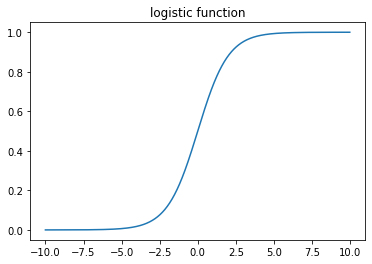

In [5]:
z = [zi/50 - 10 for zi in range(1000)]
plt.plot(z, [logistic(zi) for zi in z])
plt.title('logistic function')
plt.show()

In [6]:
def logistic_log_likelihood_i(x_i, y_i, beta):
    if y_i==1:
        return np.log(logistic(dot(x_i, beta)))
    else:
        return np.log(1 - logistic(dot(x_i, beta)))

In [7]:
def logistic_log_likelihood(x, y, beta):
    return sum(logistic_log_likelihood_i(x_i, y_i, beta)
        for x_i, y_i in zip(x, y))

In [8]:
def logistic_log_partial_ij(x_i, y_i, beta, j):
    """here i is the index of the data point, j the index of the derivative"""
    return (y_i - logistic(dot(x_i, beta))) * x_i[j]

In [9]:
def logistic_log_gradient_i(x_i, y_i, beta):
    """the gradient of the log likelihood corresponding to the ith data point"""
    return [logistic_log_partial_ij(x_i, y_i, beta, j) for j,_ in enumerate(beta)]

In [10]:
def logistic_log_gradient(x, y, beta):
    return reduce(vector_add,
        [logistic_log_gradient_i(x_i, y_i, beta) for x_i, y_i in zip(x,y)])

In [11]:
np.set_printoptions(precision=3)
breasts = datasets.load_breast_cancer()
X = breasts.data
y = breasts.target
X1 = np.insert(X, 0, 1, axis=1)

rescaled_x = rescale(X1)

# Train the model
y = np.array(y)
x = np.array(rescaled_x)

In [12]:
random.seed(0)
x_train, x_test, y_train, y_test = train_test_split(rescaled_x, y, 0.33)

# want to maximize log likelihood on the training data
fn = partial(logistic_log_likelihood, x_train, y_train)
gradient_fn = partial(logistic_log_gradient, x_train, y_train)

# pick a random starting point
beta_0 = [random.random() for _ in range(len(x_train[0]))] # and maximize using gradient descent
beta_hat, training_errs = maximize_batch(logistic_log_likelihood, logistic_log_gradient,x_train,y_train, beta_0)

beta_hat
gradient_fn
beta_hat

[0.0555270458896614,
 0.035933833430188966,
 0.4178660447962945,
 0.49183095909626395,
 0.8633251831082008,
 0.7171887463451895,
 0.6735438085995347,
 0.15137377239978678,
 0.9867059242186832,
 0.41114019628748133,
 0.6117708643248599,
 0.38668300553323576,
 0.04703291581184044,
 0.4708892090480652,
 0.15136775389483625,
 0.03246546237394399,
 0.6174004236810055,
 0.6299662912183356,
 0.10529282465636491,
 0.5491437662317772,
 0.3466679766399683,
 0.3834140731648874,
 0.7764198986996783,
 0.49031967752424566,
 0.8812766154122413,
 0.6101197429062234,
 0.4671884150380703,
 0.6323126400553846,
 0.3378653798287524,
 0.12432379252825243,
 0.6825296186925238]

In [13]:
def optimize2(x, y,learning_rate,iterations): 
    size = x.shape[0]
#     weight = parameters["weight"] 
#     bias = parameters["bias"]
    w1 = []
#     wg = np.ones(x.shape[1])
    
    for i in np.unique(y):
        y_copy = [1 if c == i else 0 for c in y]
        wg = np.ones(x.shape[1])

        for _ in range(iterations): 
            sigma = sigmoid(np.dot(x, wg))
#             loss = -1/size * np.sum(y * np.log(sigma)) + (1 - y) * np.log(1-sigma)
            dW = 1/size * np.dot(x.T, (y_copy - sigma))
#             db = 1/size * np.sum(sigma - y)
            wg += learning_rate * dW
#             bias -= learning_rate * db 
        print(wg)
        w1.append((wg,i))
#     parameters["weight"] = w1
#     parameters["bias"] = bias
    return w1

# Define the train function
# def train(x, y, learning_rate,iterations):
#     parameters_out = optimize2(x, y, learning_rate, iterations ,init_parameters)
#     return parameters_out

In [14]:
def sigmoid(x):
    return 1.0 / (1 + np.exp(-x))

def predictOne(x,w):
    return max((x.dot(w), c) for w, c in w)[1]

def predict(X,w):
    return np.array([predictOne(i,w) for i in X])

def predict2(X,w):
    output = np.insert(X, 0, 1, axis=1).dot(w)
    return (np.floor(sigmoid(output) + .5)).astype(int)

def score(X, y, w):
    return sum(predict(X,w) == y) / len(y)

In [15]:
# Initialize the weight and bais
init_parameters = {} 
# init_parameters["weight"] = np.zeros((X1.shape[1],1))
init_parameters["weight"] = np.zeros((X.shape[1],2))
init_parameters["weight"]
init_parameters["bias"] = 0
# init_parameters['weight']

In [16]:
rescaled_x = rescale(X1)

# Train the model
y = np.array(y)
x = np.array(rescaled_x)
# print(x)
parameters_out = optimize2(x, y, learning_rate = 0.01, iterations = 1000)
parameters_out

[ 0.726  1.31   1.161  1.266  1.284  0.661  0.458  0.626  0.903  0.538
  0.094  1.015  0.649  0.951  1.106  0.45   0.028  0.05   0.239  0.481
 -0.122  1.335  1.242  1.283  1.3    0.881  0.67   0.68   0.951  0.95
  0.429]
[ 1.163e+00 -2.379e-01 -2.724e-01 -2.879e-01 -2.195e-01 -1.219e-01
 -4.297e-01 -5.887e-01 -6.493e-01 -8.554e-02  5.057e-01 -3.503e-01
  3.311e-01 -3.132e-01 -1.518e-01  4.093e-01 -2.042e-02  1.375e-01
 -2.532e-01  3.860e-01  3.247e-01 -3.784e-01 -3.726e-01 -4.044e-01
 -3.034e-01 -2.306e-01 -3.156e-01 -4.395e-01 -6.250e-01 -1.440e-01
 -9.283e-04]


[(array([ 0.726,  1.31 ,  1.161,  1.266,  1.284,  0.661,  0.458,  0.626,
          0.903,  0.538,  0.094,  1.015,  0.649,  0.951,  1.106,  0.45 ,
          0.028,  0.05 ,  0.239,  0.481, -0.122,  1.335,  1.242,  1.283,
          1.3  ,  0.881,  0.67 ,  0.68 ,  0.951,  0.95 ,  0.429]),
  0),
 (array([ 1.163e+00, -2.379e-01, -2.724e-01, -2.879e-01, -2.195e-01,
         -1.219e-01, -4.297e-01, -5.887e-01, -6.493e-01, -8.554e-02,
          5.057e-01, -3.503e-01,  3.311e-01, -3.132e-01, -1.518e-01,
          4.093e-01, -2.042e-02,  1.375e-01, -2.532e-01,  3.860e-01,
          3.247e-01, -3.784e-01, -3.726e-01, -4.044e-01, -3.034e-01,
         -2.306e-01, -3.156e-01, -4.395e-01, -6.250e-01, -1.440e-01,
         -9.283e-04]),
  1)]

In [17]:
X1 = np.insert(X, 0, 1, axis=1)
# X1 = X
wg = []

for i in np.unique(y):
    y_copy = [1 if c == i else 0 for c in y]
    w = np.ones(X1.shape[1])
    print(w.shape)
    eta = 0.001
    size = X1.shape[0]

    # print('training ', i)
    # counter = 0

    for _ in range(1000):
        output = X1.dot(w)
        errors = y_copy - sigmoid(output)
        w += eta * 1/size * errors.T.dot(X1)
#         diff = -eta * 1/size * errors.T.dot(X1)
        
#         if np.all(np.abs(diff) <= 1e-06):
#             break
#         w += diff

        # counter += 1
        # if counter // 10 == 0:
        #     print(sum(errors**2) / 2.0)
    wg.append((w, i))

(31,)
(31,)


C:\Users\USER\AppData\Local\Temp/ipykernel_2872/748271318.py:2: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1 + np.exp(-x))


In [18]:
wg

[(array([ 0.936,  0.515,  0.108, -1.904, -0.917,  0.995,  0.999,  1.005,
          1.002,  0.99 ,  0.996,  0.991,  0.929,  0.96 ,  1.535,  1.   ,
          1.   ,  1.   ,  1.   ,  0.999,  1.   ,  0.479, -0.166, -2.055,
          1.12 ,  0.993,  1.001,  1.009,  1.002,  0.986,  0.996]),
  0),
 (array([ 1.016,  1.12 ,  0.976,  1.605,  0.47 ,  1.001,  0.997,  0.994,
          0.998,  1.001,  1.001,  0.995,  0.992,  0.948,  0.045,  1.   ,
          0.999,  0.999,  1.   ,  1.   ,  1.   ,  1.121,  0.936,  1.496,
         -0.861,  1.   ,  0.99 ,  0.985,  0.996,  1.   ,  1.   ]),
  1)]

In [19]:
wg_0 = wg[0][0]
wg_0 = wg_0.reshape(len(wg_0),1)
wg_0.shape
# wg_0

(31, 1)

In [20]:
wg_1 = wg[1][0]
wg_1 = wg_1.reshape(len(wg_1),1)
wg_1.shape
# wg_1

(31, 1)

In [21]:
rescaled_x = rescale(X1)
rescaled_x = np.array(rescaled_x)
score(X1,y,wg)

0.9226713532513181

In [22]:
random.seed(0)
rescaled_x = rescale(X1)

# Train the model
y = np.array(y)
x = np.array(X1)
# print(x)
parameters_out = optimize2(x, y, learning_rate = 0.01, iterations = 1000)
parameters_out

C:\Users\USER\AppData\Local\Temp/ipykernel_2872/748271318.py:2: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1 + np.exp(-x))


[  0.601  -2.036  -3.286 -16.708  -5.997   0.971   1.01    1.053   1.023
   0.946   0.977   0.984   0.715   1.053   8.219   0.998   1.003   1.006
   1.001   0.995   1.     -2.244  -4.457 -17.156   9.256   0.964   1.049
   1.108   1.025   0.925   0.978]
[  1.384   3.934   4.897  18.019   7.779   1.027   0.987   0.945   0.977
   1.051   1.021   1.003   1.251   0.858  -7.299   1.001   0.996   0.993
   0.999   1.004   1.      4.089   5.918  18.129 -10.597   1.033   0.944
   0.886   0.974   1.069   1.019]


[(array([  0.601,  -2.036,  -3.286, -16.708,  -5.997,   0.971,   1.01 ,
           1.053,   1.023,   0.946,   0.977,   0.984,   0.715,   1.053,
           8.219,   0.998,   1.003,   1.006,   1.001,   0.995,   1.   ,
          -2.244,  -4.457, -17.156,   9.256,   0.964,   1.049,   1.108,
           1.025,   0.925,   0.978]),
  0),
 (array([  1.384,   3.934,   4.897,  18.019,   7.779,   1.027,   0.987,
           0.945,   0.977,   1.051,   1.021,   1.003,   1.251,   0.858,
          -7.299,   1.001,   0.996,   0.993,   0.999,   1.004,   1.   ,
           4.089,   5.918,  18.129, -10.597,   1.033,   0.944,   0.886,
           0.974,   1.069,   1.019]),
  1)]

In [23]:
# # Y = TypeVar('Y')  # generic type to represent output variables

# # def split_data(data: List[X], prob: float) -> Tuple[List[X], List[X]]:
# #     """Split data into fractions [prob, 1 - prob]"""
# #     data = data[:]                    # Make a shallow copy
# #     random.shuffle(data)              # because shuffle modifies the list.
# #     cut = int(len(data) * prob)       # Use prob to find a cutoff
# #     return data[:cut], data[cut:]     # and split the shuffled list there.

# def	split_data(data,	prob):
# 				"""split	data	into	fractions	[prob,	1	-	prob]"""
# 				results	=	[],	[]
# 				for	row	in	data:
# 								results[0	if	random.random()	<	prob	else	1].append(row)
# 				return	results

# # def train_test_split(xs,ys,test_pct):                                                      

# #     # Generate the indices and split them
# #     idxs = [i for i in range(len(xs))]
# #     train_idxs, test_idxs = split_data(idxs, 1 - test_pct)

# #     return ([xs[i] for i in train_idxs],  # x_train 
# #             [xs[i] for i in test_idxs],   # x_test
# #             [ys[i] for i in train_idxs],  # y_train
# #             [ys[i] for i in test_idxs])   # y_test

# def	train_test_split(x,	y,	test_pct):
#     data	=	zip(x,	y)																														#	pair	corresponding	values
#     train,	test	=	split_data(data,	1	-	test_pct)		#	split	the	data	set	of	pairs
#     x_train,	y_train	=	zip(*train)																#	magical	un-zip	trick
#     x_test,	y_test	=	zip(*test)
#     return x_train, x_test, y_train, y_test

In [24]:
random.seed(0)
rescaled_x = rescale(X1)

# Train the model
y = np.array(y)
x = np.array(X1)
# print(x)
parameters_out = optimize2(x, y, learning_rate = 0.01, iterations = 1000)
parameters_out

C:\Users\USER\AppData\Local\Temp/ipykernel_2872/748271318.py:2: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1 + np.exp(-x))


[  0.601  -2.036  -3.286 -16.708  -5.997   0.971   1.01    1.053   1.023
   0.946   0.977   0.984   0.715   1.053   8.219   0.998   1.003   1.006
   1.001   0.995   1.     -2.244  -4.457 -17.156   9.256   0.964   1.049
   1.108   1.025   0.925   0.978]
[  1.384   3.934   4.897  18.019   7.779   1.027   0.987   0.945   0.977
   1.051   1.021   1.003   1.251   0.858  -7.299   1.001   0.996   0.993
   0.999   1.004   1.      4.089   5.918  18.129 -10.597   1.033   0.944
   0.886   0.974   1.069   1.019]


[(array([  0.601,  -2.036,  -3.286, -16.708,  -5.997,   0.971,   1.01 ,
           1.053,   1.023,   0.946,   0.977,   0.984,   0.715,   1.053,
           8.219,   0.998,   1.003,   1.006,   1.001,   0.995,   1.   ,
          -2.244,  -4.457, -17.156,   9.256,   0.964,   1.049,   1.108,
           1.025,   0.925,   0.978]),
  0),
 (array([  1.384,   3.934,   4.897,  18.019,   7.779,   1.027,   0.987,
           0.945,   0.977,   1.051,   1.021,   1.003,   1.251,   0.858,
          -7.299,   1.001,   0.996,   0.993,   0.999,   1.004,   1.   ,
           4.089,   5.918,  18.129, -10.597,   1.033,   0.944,   0.886,
           0.974,   1.069,   1.019]),
  1)]

In [25]:
random.seed(0)
# rescaled_x = rescale(X1)

# X_train,X_test,y_train,y_test=train_test_split(X1,breasts.target,0.4)

In [26]:
# # beta_0 = parameters_out['weight']
# beta_0 = parameters_out[0][0]
# # print(beta_0)
# X_train = np.array(X_train)
# y_train = np.array(y_train)

In [27]:
def train_test_split(xs, ys, test_pct):
     # Generate the indices and split them
    idxs = [i for i in range(len(xs))]
    train_idxs, test_idxs = split_data(idxs, 1 - test_pct)

    return ([xs[i] for i in train_idxs],  # x_train 
            [xs[i] for i in test_idxs],   # x_test
            [ys[i] for i in train_idxs],  # y_train
            [ys[i] for i in test_idxs])   # y_test
                                                                
def minimize_batch(target_fn, gradient_fn, theta_0, tolerance=0.000001):
    """use gradient descent to find theta that minimizes target function"""

    step_sizes = [100, 10, 1, 0.1, 0.01, 0.001, 0.0001, 0.00001]

    theta = theta_0                           # set theta to initial value
    target_fn = safe(target_fn)               # safe version of target_fn
    value = target_fn(theta)                  # value we're minimizing

    while True:
        gradient = gradient_fn(theta)
        next_thetas = [step(theta, gradient, -step_size)
                       for step_size in step_sizes]

        # choose the one that minimizes the error function
        next_theta = min(next_thetas, key=target_fn)
        next_value = target_fn(next_theta)

        # stop if we're "converging"
        if abs(value - next_value) < tolerance:
            return theta
        else:
            theta, value = next_theta, next_value
    
    
def maximize_batch(target_fn, gradient_fn, theta_0, tolerance=0.000001):
    return minimize_batch(negate(target_fn),
                          negate_all(gradient_fn),
                          theta_0,
                          tolerance)

In [28]:
# random.seed(0)
# x_train, x_test, y_train, y_test = train_test_split(rescaled_x, y, 0.33)

# # want to maximize log likelihood on the training data
# fn = partial(logistic_log_likelihood, x_train, y_train)
# gradient_fn = partial(logistic_log_gradient, x_train, y_train)

# # pick a random starting point
# # beta_0 = [random.random() for _ in range(len(x_train[0]))] # and maximize using gradient descent
# beta_0 = parameters_out[0][0]
# beta_hat, training_errs = maximize_batch(logistic_log_likelihood, logistic_log_gradient,x_train,y_train, beta_0)

# beta_hat
# gradient_fn
# beta_hat

In [29]:
import tqdm

random.seed(0)

x_train, x_test, y_train, y_test = train_test_split(rescaled_x, y, 0.4)
print(len(y_train))
print(len(x_train))

learning_rate = 0.0000001

# beta_00 = [random.random() for _ in range(len(x_train[0]))] # and maximize using gradient descent
# # print(beta_00)

beta_00 = parameters_out[0][0]

with tqdm.trange(300) as t:
    for epoch in t:
        gradient = negative_log_gradient(x_train, y_train, beta_00)
        beta_00 = gradient_step(beta_00, gradient, -learning_rate)
        loss = negative_log_likelihood(x_train, y_train, beta_00)
        print(sum(gradient))
        t.set_description(f"loss: {loss:.3f} gradient: {gradient}")
        
# print(beta_00)

341
341


  0%|                                                                                                                                              | 0/300 [00:00<?, ?it/s]C:\Users\USER\AppData\Local\Temp/ipykernel_2872/1774041217.py:161: RuntimeWarning: divide by zero encountered in log
  return -np.log(1 - logistic(dot(x, beta)))
loss: inf gradient: [-23.31390305587511, 2.2430297641042025, -19.850226880060664, 7.142732144701283, 4.5976340643756535, 81.18138426344665, 75.29074042335654, 61.841072840

1229.4037292168614


loss: inf gradient: [-23.31370792739297, 2.242918832231514, -19.850354975824526, 7.142601103973195, 4.5975102599297175, 81.18108978850981, 75.29039693245478, 61.8407502940

1229.3973893326715


loss: inf gradient: [-23.313512797007633, 2.242807903847593, -19.850483069497372, 7.142470066671237, 4.597386459540926, 81.18079531469586, 75.2900534416842, 61.84042775042

1229.3910494916167


loss: inf gradient: [-23.313317664719364, 2.242696978952378, -19.85061116107899, 7.1423390327954035, 4.597262663209091, 81.18050084200578, 75.28970995104564, 61.8401052094

1229.3847096937093


loss: inf gradient: [-23.313122530528517, 2.2425860575458127, -19.850739250569074, 7.142208002345701, 4.597138870934028, 81.18020637044023, 75.28936646054034, 61.839782671

1229.378369938962


loss: inf gradient: [-23.31292739443539, 2.242475139627827, -19.850867337967347, 7.142076975322128, 4.597015082715549, 81.17991190000019, 75.28902297016899, 61.83946013548

1229.3720302273864


loss: inf gradient: [-23.312732256440242, 2.242364225198359, -19.85099542327359, 7.141945951724687, 4.596891298553459, 81.17961743068625, 75.28867947993251, 61.83913760247

1229.3656905589964


loss: inf gradient: [-23.31253711654344, 2.242253314257348, -19.851123506487486, 7.141814931553381, 4.596767518447578, 81.1793229624994, 75.28833598983195, 61.838815072118

1229.3593509338039


loss: inf gradient: [-23.312341974745262, 2.242142406804727, -19.85125158760883, 7.1416839148081905, 4.596643742397713, 81.17902849544026, 75.28799249986824, 61.8384925444

1229.3530113518207


loss: inf gradient: [-23.312146831046004, 2.2420315028404336, -19.851379666637325, 7.14155290148914, 4.596519970403678, 81.1787340295097, 75.2876490100421, 61.838170019373

1229.3466718130599


loss: inf gradient: [-23.31195168544599, 2.2419206023644, -19.851507743572714, 7.141421891596207, 4.596396202465277, 81.17843956470855, 75.28730552035476, 61.8378474969855

1229.3403323175337


loss: inf gradient: [-23.311756537945506, 2.2418097053765664, -19.851635818414728, 7.141290885129407, 4.596272438582334, 81.17814510103763, 75.28696203080695, 61.837524977

1229.333992865254


loss: inf gradient: [-23.311561388544902, 2.241698811876876, -19.8517638911631, 7.14115988208874, 4.596148678754659, 81.17785063849769, 75.28661854139972, 61.8372024601807

1229.327653456235


loss: inf gradient: [-23.311366237244453, 2.2415879218652606, -19.85189196181759, 7.141028882474203, 4.596024922982069, 81.17755617708957, 75.2862750521339, 61.83687994576

1229.3213140904875


loss: inf gradient: [-23.311171084044446, 2.241477035341657, -19.852020030377922, 7.140897886285793, 4.595901171264376, 81.17726171681406, 75.28593156301044, 61.8365574340

1229.3149747680252


loss: inf gradient: [-23.310975928945233, 2.2413661523059947, -19.852148096843816, 7.140766893523515, 4.595777423601372, 81.17696725767186, 75.28558807403029, 61.836234924

1229.3086354888587


loss: inf gradient: [-23.310780771947066, 2.241255272758218, -19.852276161215034, 7.140635904187359, 4.595653679992893, 81.17667279966406, 75.28524458519445, 61.8359124184

1229.3022962530026


loss: inf gradient: [-23.310585613050304, 2.241144396698264, -19.852404223491295, 7.1405049182773475, 4.595529940438744, 81.17637834279108, 75.28490109650375, 61.835589914

1229.295957060468


loss: inf gradient: [-23.31039045225523, 2.241033524126066, -19.852532283672353, 7.1403739357934475, 4.59540620493873, 81.17608388705399, 75.28455760795913, 61.83526741358

1229.2896179112674


loss: inf gradient: [-23.31019528956215, 2.2409226550415715, -19.852660341757936, 7.140242956735695, 4.595282473492683, 81.17578943245344, 75.28421411956161, 61.8349449151

1229.2832788054145


loss: inf gradient: [-23.310000124971385, 2.240811789444706, -19.85278839774775, 7.140111981104067, 4.595158746100403, 81.17549497899039, 75.28387063131204, 61.83462241935

1229.2769397429206


loss: inf gradient: [-23.30980495848324, 2.240700927335413, -19.852916451641587, 7.13998100889858, 4.595035022761708, 81.17520052666552, 75.28352714321136, 61.834299926226

1229.270600723798


loss: inf gradient: [-23.30960979009799, 2.2405900687136273, -19.85304450343917, 7.139850040119223, 4.594911303476405, 81.17490607547958, 75.28318365526049, 61.83397743576

1229.2642617480599


loss: inf gradient: [-23.30941461981597, 2.240479213579289, -19.853172553140205, 7.139719074765994, 4.594787588244318, 81.17461162543351, 75.28284016746038, 61.83365494797

1229.257922815719


loss: inf gradient: [-23.309219447637528, 2.2403683619323367, -19.85330060074444, 7.1395881128389185, 4.594663877065251, 81.17431717652806, 75.28249667981208, 61.833332462

1229.2515839267871


loss: inf gradient: [-23.309024273562873, 2.2402575137727005, -19.853428646251636, 7.139457154337969, 4.594540169939025, 81.17402272876402, 75.28215319231631, 61.833009980

1229.2452450812768


loss: inf gradient: [-23.30882909759238, 2.240146669100328, -19.853556689661488, 7.139326199263158, 4.59441646686545, 81.17372828214212, 75.28180970497415, 61.832687500591

1229.2389062792006


loss: inf gradient: [-23.30863391972637, 2.240035827915148, -19.8536847309738, 7.13919524761449, 4.59429276784434, 81.17343383666334, 75.28146621778639, 61.83236502346515,

1229.2325675205711


loss: inf gradient: [-23.30843873996507, 2.2399249902171032, -19.853812770188227, 7.139064299391959, 4.594169072875502, 81.17313939232835, 75.28112273075408, 61.8320425490

1229.226228805401


loss: inf gradient: [-23.3082435583089, 2.2398141560061333, -19.853940807304554, 7.13893335459557, 4.594045381958765, 81.17284494913798, 75.2807792438783, 61.8317200772203

1229.2198901337026


loss: inf gradient: [-23.30804837475808, 2.2397033252821705, -19.854068842322533, 7.138802413225322, 4.593921695093929, 81.17255050709306, 75.28043575715961, 61.8313976081

1229.2135515054879


loss: inf gradient: [-23.307853189312965, 2.2395924980451585, -19.854196875241843, 7.1386714752812255, 4.593798012280822, 81.17225606619431, 75.28009227059921, 61.83107514

1229.2072129207704


loss: inf gradient: [-23.307658001973838, 2.239481674295029, -19.85432490606226, 7.138540540763274, 4.593674333519242, 81.1719616264426, 75.27974878419802, 61.830752677880

1229.2008743795618


loss: inf gradient: [-23.307462812741, 2.2393708540317316, -19.85445293478352, 7.138409609671471, 4.593550658809022, 81.17166718783865, 75.27940529795683, 61.8304302167776

1229.1945358818746


loss: inf gradient: [-23.3072676216148, 2.2392600372551867, -19.854580961405368, 7.138278682005821, 4.593426988149956, 81.17137275038347, 75.27906181187677, 61.83010775834

1229.1881974277217


loss: inf gradient: [-23.306877233683466, 2.2390384141621555, -19.854837008349726, 7.138016836952959, 4.593179658984593, 81.170783878922, 75.27837484020328, 61.82946284950

1229.1818590171156
1229.175520650068


loss: inf gradient: [-23.30648683818228, 2.238816805015432, -19.85509304689323, 7.137755005604725, 4.592932346021659, 81.1701950120647, 75.27768786918512, 61.8288179513691

1229.1691823265921
1229.1628440467014


loss: inf gradient: [-23.3060964351137, 2.238595209814522, -19.85534907703377, 7.137493187961122, 4.59268504925967, 81.16960614981795, 75.27700089882966, 61.82817306393527

1229.1565058104059
1229.15016761772


loss: inf gradient: [-23.305510816327402, 2.23826284316049, -19.85573310648443, 7.137100487191936, 4.592314134490228, 81.16872286510659, 75.27597044455538, 61.827205752869

1229.1438294686561
1229.1374913632255
1229.131153301442


loss: inf gradient: [-23.3051203943512, 2.2380412828219822, -19.85598911560837, 7.136838703809992, 4.592066878224147, 81.16813401441425, 75.27528347588945, 61.826560892223

1229.1248152833175
1229.1184773088648


loss: inf gradient: [-23.30472996481625, 2.237819736427577, -19.856245116321983, 7.136576934132738, 4.591819638153844, 81.16754516835483, 75.27459650791229, 61.82591604230

1229.1121393780961
1229.105801491024


loss: inf gradient: [-23.304339527725077, 2.237598203976786, -19.85650110862317, 7.136315178160202, 4.59157241427784, 81.16695632693498, 75.2739095406314, 61.8252712031106

1229.0994636476614
1229.09312584802


loss: inf gradient: [-23.303949083080123, 2.2373766854691266, -19.856757092509834, 7.1360534358924035, 4.591325206594663, 81.1663674901609, 75.27322257405439, 61.824626374

1229.0867880921132
1229.080450379953


loss: inf gradient: [-23.303558630883863, 2.2371551809041184, -19.85701306797987, 7.1357917073293695, 4.591078015102849, 81.16577865803909, 75.27253560818856, 61.823981556

1229.074112711552
1229.0677750869231


loss: inf gradient: [-23.303168171138793, 2.2369336902812607, -19.85726903503113, 7.135529992471107, 4.590830839800907, 81.16518983057588, 75.27184864304144, 61.8233367499

1229.0614375060777
1229.0550999690295


loss: inf gradient: [-23.302777703847394, 2.2367122136000823, -19.857524993661578, 7.1352682913176535, 4.590583680687386, 81.16460100777779, 75.27116167862052, 61.82269195

1229.0487624757907
1229.042425026374


loss: inf gradient: [-23.302387229012126, 2.2364907508600904, -19.857780943869074, 7.1350066038690265, 4.5903365377608045, 81.16401218965125, 75.27047471493319, 61.8220471

1229.036087620791
1229.0297502590556


loss: inf gradient: [-23.3019967466355, 2.236269302060818, -19.85803688565152, 7.134744930125256, 4.590089411019704, 81.16342337620264, 75.26978775198701, 61.8214023936121

1229.02341294118
1229.0170756671757


loss: inf gradient: [-23.30160625671999, 2.2360478672017723, -19.85829281900685, 7.134483270086372, 4.58984230046261, 81.1628345674383, 75.26910078978946, 61.8207576296888

1229.0107384370558
1229.0044012508333


loss: inf gradient: [-23.301215759268068, 2.2358264462824895, -19.858548743932907, 7.134221623752409, 4.589595206088077, 81.16224576336477, 75.26841382834789, 61.820112876

1228.9980641085206
1228.9917270101296


loss: inf gradient: [-23.30082525428224, 2.2356050393024796, -19.858804660427612, 7.133959991123384, 4.589348127894629, 81.16165696398843, 75.26772686766986, 61.8194681341

1228.985389955674
1228.979052945165


loss: inf gradient: [-23.30023948268285, 2.235272954967558, -19.859188519356305, 7.1335675678766695, 4.588977540940794, 81.16077377374528, 75.26669642810091, 61.8185010408

1228.972715978616
1228.9663790560387
1228.9600421774473


loss: inf gradient: [-23.299848958873156, 2.2350515828336426, -19.859444414763445, 7.133305969510128, 4.588730503193659, 81.16018498614008, 75.26600946936443, 61.817856325

1228.9537053428528
1228.9473685522682


loss: inf gradient: [-23.29945842753824, 2.2348302246373377, -19.85970030173187, 7.133044384848642, 4.588483481622504, 81.15959620325452, 75.26532251141755, 61.81721162085

1228.9410318057064
1228.9346951031796


loss: inf gradient: [-23.299067888680646, 2.2346088803781674, -19.85995618025947, 7.132782813892242, 4.588236476225873, 81.15900742509514, 75.26463555426795, 61.8165669270

1228.9283584447005
1228.9220218302812


loss: inf gradient: [-23.29867734230283, 2.23438755005566, -19.860212050344177, 7.132521256640966, 4.587989487002304, 81.15841865166821, 75.26394859792293, 61.815922244092

1228.9156852599351
1228.909348733674


loss: inf gradient: [-23.298286788407317, 2.234166233669349, -19.860467911983868, 7.132259713094847, 4.587742513950345, 81.15782988298028, 75.26326164239006, 61.8152775719

1228.903012251511
1228.8966758134582


loss: inf gradient: [-23.297896226996574, 2.2339449312187507, -19.860723765176477, 7.131998183253923, 4.587495557068547, 81.15724111903772, 75.26257468767682, 61.814632910

1228.8903394195286
1228.8840030697347


loss: inf gradient: [-23.297505658073128, 2.233723642703403, -19.860979609919852, 7.131736667118222, 4.587248616355448, 81.15665235984703, 75.26188773379063, 61.8139882600

1228.8776667640884
1228.871330502603


loss: inf gradient: [-23.297115081639472, 2.2335023681228434, -19.861235446211907, 7.131475164687808, 4.587001691809616, 81.1560636054145, 75.2612007807389, 61.81334362040

1228.8649942852915
1228.8586581121647


loss: inf gradient: [-23.29672449769811, 2.233281107476596, -19.86149127405055, 7.131213675962703, 4.586754783429586, 81.15547485574663, 75.26051382852923, 61.812698991564

1228.8523219832368
1228.8459858985207
1228.8396498580275

loss: inf gradient: [-23.296333906251558, 2.233059860764199, -19.861747093433685, 7.130952200942952, 4.586507891213924, 81.15488611084989, 75.25982687716909, 61.8120543735


1228.83331386177


loss: inf gradient: [-23.29574800501492, 2.2327280168205434, -19.862130806649713, 7.1305600141109515, 4.586137583195436, 81.15400300246462, 75.25879645173812, 61.811087466

1228.8269779097618
1228.8206420020144
1228.8143061385413


loss: inf gradient: [-23.295357394816318, 2.232506804940735, -19.862386604884865, 7.130298573354775, 4.585890731384356, 81.15341426952376, 75.25810950253451, 61.8104428760

1228.8079703193544
1228.8016345444667


loss: inf gradient: [-23.29496677712126, 2.232285606993149, -19.862642394657172, 7.130037146304107, 4.585643895732581, 81.1528255413765, 75.25742255420663, 61.809798296064

1228.7952988138907
1228.788963127639


loss: inf gradient: [-23.294576151932286, 2.232064422977315, -19.862898175964553, 7.129775732958979, 4.5853970762386655, 81.1522368180293, 75.25673560676192, 61.8091537269

1228.782627485724
1228.776291888158


loss: inf gradient: [-23.294185519251904, 2.2318432528927854, -19.863153948804808, 7.129514333319459, 4.58515027290118, 81.15164809948845, 75.25604866020784, 61.8085091686

1228.7699563349545
1228.7636208261258


loss: inf gradient: [-23.293794879082636, 2.231622096739093, -19.863409713175944, 7.129252947385581, 4.584903485718676, 81.15105938576056, 75.25536171455194, 61.8078646213

1228.7572853616832
1228.7509499416412


loss: inf gradient: [-23.293208904792507, 2.231290388627881, -19.86379334384839, 7.128860894182961, 4.584533335232389, 81.15017632420708, 75.25433129776859, 61.80689782066

1228.7446145660115
1228.7382792348064
1228.7319439480398


loss: inf gradient: [-23.29281824591198, 2.2310692672992873, -19.864049087037458, 7.128599542513421, 4.584286588431081, 81.14958762253961, 75.25364435439074, 61.8062533005

1228.7256087057224
1228.719273507868


loss: inf gradient: [-23.292232243566804, 2.230737611423576, -19.864432685926964, 7.128207540707547, 4.583916498509848, 81.14870457910683, 75.2526139410597, 61.80528654074

1228.7129383544896
1228.7066032455984
1228.7002681812078


loss: inf gradient: [-23.291646224399894, 2.2304059868871176, -19.864816265737254, 7.127815569739948, 4.583546444921207, 81.14782154657544, 75.2515835298337, 61.8043198055

1228.6939331613307
1228.6875981859791
1228.6812632551662


loss: inf gradient: [-23.291255535614116, 2.230184921272743, -19.865071975007705, 7.127554272894013, 4.583299762711163, 81.14723286428827, 75.25089659019837, 61.8036753289

1228.6749283689046
1228.668593527206


loss: inf gradient: [-23.290864839358292, 2.2299638695857893, -19.865327675793278, 7.127292989754123, 4.583053096645358, 81.14664418686236, 75.25020965151738, 61.803030863

1228.6622587300847
1228.6559239775513


loss: inf gradient: [-23.290474135634984, 2.229742831825813, -19.86558336809188, 7.127031720320322, 4.582806446722376, 81.14605551430391, 75.24952271379817, 61.80238640873

1228.6495892696198
1228.6432546063027


loss: inf gradient: [-23.290083424446745, 2.2295218079923527, -19.86583905190139, 7.126770464592677, 4.582559812940783, 81.14546684661954, 75.24883577704831, 61.8017419650

1228.6369199876115
1228.6305854135594


loss: inf gradient: [-23.289692705796046, 2.2293007980849686, -19.866094727219707, 7.12650922257125, 4.582313195299159, 81.14487818381562, 75.24814884127532, 61.8010975322

1228.6242508841608
1228.6179163994257


loss: inf gradient: [-23.28930197968544, 2.2290798021032057, -19.866350394044773, 7.1262479942560875, 4.582066593796085, 81.14428952589863, 75.24746190648662, 61.800453110

1228.6115819593686
1228.6052475640006


loss: inf gradient: [-23.288911246117447, 2.2288588200466157, -19.86660605237444, 7.125986779647259, 4.581820008430123, 81.14370087287506, 75.24677497268965, 61.7998086994

1228.5989132133354
1228.5925789073854


loss: inf gradient: [-23.288520505094617, 2.2286378519147565, -19.86686170220665, 7.125725578744815, 4.581573439199875, 81.14311222475114, 75.24608803989202, 61.7991642995

1228.586244646163
1228.5799104296816


loss: inf gradient: [-23.28812975661946, 2.228416897707188, -19.867117343539284, 7.125464391548843, 4.581326886103915, 81.14252358153362, 75.24540110810122, 61.79851991055

1228.573576257953
1228.56724213099


loss: inf gradient: [-23.28773900069453, 2.2281959574234502, -19.867372976370266, 7.1252032180593865, 4.581080349140816, 81.14193494322869, 75.2447141773247, 61.7978755325

1228.560908048805
1228.5545740114117


loss: inf gradient: [-23.287348237322345, 2.2279750310631106, -19.867628600697483, 7.124942058276516, 4.5808338283091645, 81.14134630984282, 75.24402724756997, 61.79723116

1228.5482400188212
1228.5419060710474


loss: inf gradient: [-23.28695746650545, 2.2277541186257186, -19.867884216518863, 7.124680912200288, 4.580587323607549, 81.14075768138268, 75.24334031884449, 61.7965868094

1228.5355721681021
1228.5292383099984


loss: inf gradient: [-23.286566688246385, 2.227533220110849, -19.868139823832262, 7.1244197798307844, 4.5803408350345665, 81.14016905785445, 75.24265339115583, 61.79594246

1228.5229044967496
1228.5165707283668


loss: inf gradient: [-23.286175902547672, 2.22731233551804, -19.86839542263566, 7.124158661168057, 4.58009436258878, 81.13958043926466, 75.24196646451153, 61.7952981302749

1228.5102370048635
1228.5039033262528


loss: inf gradient: [-23.2857851094119, 2.2270914648468723, -19.86865101292689, 7.123897556212199, 4.579847906268804, 81.13899182561981, 75.24127953891897, 61.794653807181

1228.497569692547
1228.4912361037584


loss: inf gradient: [-23.285394308841543, 2.226870608096895, -19.868906594703912, 7.123636464963252, 4.579601466073221, 81.13840321692622, 75.24059261438578, 61.7940094950

1228.4849025598996
1228.4785690609842


loss: inf gradient: [-23.28480809405178, 2.2265393490732004, -19.869289951400656, 7.123244853790463, 4.5792318360099875, 81.13752031318374, 75.23956222958851, 61.793043047

1228.4722356070233
1228.4659021980312
1228.4595688340194


loss: inf gradient: [-23.28422186254859, 2.22620812136975, -19.86967328892861, 7.122853273458663, 4.578862242218737, 81.13663742061802, 75.2385318472169, 61.79207662486498

1228.4532355150016
1228.4469022409892
1228.4405690119959


loss: inf gradient: [-23.28383103226547, 2.225987320300182, -19.869928836627768, 7.122592237038132, 4.578615866506647, 81.13604883179418, 75.23784492699596, 61.79143235682

1228.4342358280337
1228.427902689116


loss: inf gradient: [-23.283440194560544, 2.2257665331496335, -19.870184375802197, 7.122331214324888, 4.578369506911931, 81.13546024795401, 75.2371580078718, 61.7907880998

1228.4215695952544
1228.4152365464633


loss: inf gradient: [-23.28304934943634, 2.225545759917671, -19.870439906449885, 7.12207020531901, 4.578123163433175, 81.13487166910382, 75.23647108985192, 61.790143853847

1228.4089035427537
1228.4025705841386


loss: inf gradient: [-23.282658496895397, 2.225325000603855, -19.870695428568652, 7.121809210020569, 4.577876836068982, 81.13428309525005, 75.23578417294394, 61.7894996189

1228.3962376706313
1228.3899048022436


loss: inf gradient: [-23.2822676369403, 2.225104255207764, -19.870950942156405, 7.1215482284296385, 4.5776305248179545, 81.13369452639931, 75.23509725715539, 61.7888553950

1228.383571978989
1228.3772392008802


loss: inf gradient: [-23.281876769573596, 2.224883523728969, -19.87120644721114, 7.1212872605463176, 4.577384229678699, 81.13310596255774, 75.23441034249366, 61.7882111821

1228.3709064679292
1228.364573780149


loss: inf gradient: [-23.281485894797807, 2.2246628061670357, -19.871461943730683, 7.1210263063706645, 4.577137950649813, 81.1325174037321, 75.2337234289663, 61.7875669804

1228.358241137552
1228.351908540152


loss: inf gradient: [-23.28109501261556, 2.224442102521537, -19.87171743171299, 7.1207653659027725, 4.576891687729903, 81.13192884992868, 75.2330365165808, 61.786922789683

1228.3455759879607
1228.339243480991


loss: inf gradient: [-23.28070412302933, 2.224221412792054, -19.87197291115592, 7.12050443914272, 4.576645440917582, 81.131340301154, 75.23234960534477, 61.78627861003038,

1228.332911019255
1228.3265786027664


loss: inf gradient: [-23.28011777477321, 2.2238904042894205, -19.872356114304498, 7.120113074705022, 4.576276100897785, 81.13045748743478, 75.2313192406621, 61.78531236131

1228.320246231537
1228.3139139055806
1228.3075816249088


loss: inf gradient: [-23.27972686668834, 2.2236697493480984, -19.87261157238993, 7.119852182214924, 4.576029894348332, 81.12986895126008, 75.23063233233238, 61.78466820935

1228.3012493895346
1228.2949171994712


loss: inf gradient: [-23.27933595120846, 2.2234491083213035, -19.87286702192868, 7.119591303432964, 4.575783703901603, 81.12928042013668, 75.2299454251784, 61.784024068483

1228.2885850547311
1228.2822529553264


loss: inf gradient: [-23.278945028336196, 2.2232284812086163, -19.873122462918683, 7.119330438359226, 4.575537529556208, 81.12869189407091, 75.2292585192076, 61.7833799387

1228.2759209012704
1228.2695888925755


loss: inf gradient: [-23.278554098074068, 2.2230078680096104, -19.87337789535781, 7.119069586993795, 4.575291371310762, 81.1281033730694, 75.22857161442748, 61.78273582002

1228.263256929255
1228.2569250113208


loss: inf gradient: [-23.278163160424672, 2.222787268723861, -19.87363331924405, 7.118808749336754, 4.575045229163867, 81.1275148571386, 75.22788471084561, 61.782091712444

1228.2505931387855
1228.2442613116632


loss: inf gradient: [-23.277772215390538, 2.222566683350958, -19.87388873457521, 7.118547925388202, 4.574799103114156, 81.12692634628488, 75.22719780846963, 61.78144761597

1228.2379295299654
1228.2315977937049


loss: inf gradient: [-23.2773812629743, 2.222346111890486, -19.874144141349262, 7.118287115148226, 4.57455299316025, 81.12633784051467, 75.22651090730686, 61.780803530624,

1228.2252661028945
1228.2189344575472


loss: inf gradient: [-23.276990303178465, 2.222125554342017, -19.8743995395641, 7.11802631861691, 4.574306899300751, 81.1257493398345, 75.22582400736485, 61.78015945639186

1228.2126028576756
1228.2062713032924


loss: inf gradient: [-23.27659933600563, 2.221905010705139, -19.87465492921765, 7.117765535794357, 4.574060821534295, 81.12516084425062, 75.22513710865115, 61.779515393285

1228.1999397944103
1228.1936083310418


loss: inf gradient: [-23.276208361458366, 2.2216844809794365, -19.874910310307797, 7.117504766680653, 4.573814759859493, 81.12457235376979, 75.22445021117332, 61.778871341

1228.1872769131999
1228.1809455408968


loss: inf gradient: [-23.275817379539276, 2.2214639651645016, -19.87516568283246, 7.117244011275898, 4.573568714274977, 81.12398386839834, 75.22376331493892, 61.7782273004

1228.1746142141467
1228.1682829329602


loss: inf gradient: [-23.275426390250903, 2.2212434632599187, -19.87542104678955, 7.116983269580185, 4.57332268477937, 81.12339538814268, 75.22307641995536, 61.77758327078

1228.161951697352
1228.1556205073332


loss: inf gradient: [-23.275035393595832, 2.2210229752652673, -19.875676402177, 7.116722541593607, 4.573076671371289, 81.12280691300941, 75.22238952623012, 61.776939252237

1228.1492893629174
1228.1429582641176


loss: inf gradient: [-23.27464438957665, 2.2208025011801373, -19.87593174899269, 7.11646182731626, 4.572830674049371, 81.12221844300484, 75.22170263377083, 61.776295244847

1228.1366272109458
1228.1302962034147


loss: inf gradient: [-23.274253378195926, 2.2205820410041266, -19.876187087234555, 7.116201126748244, 4.572584692812237, 81.12162997813545, 75.22101574258507, 61.775651248

1228.1239652415384
1228.1176343253276


loss: inf gradient: [-23.273862359456235, 2.220361594736821, -19.87644241690047, 7.115940439889661, 4.57233872765853, 81.12104151840772, 75.22032885268028, 61.775007263552

1228.1113034547964
1228.1049726299577


loss: inf gradient: [-23.273471333360195, 2.2201411623778156, -19.876697737988394, 7.115679766740614, 4.572092778586876, 81.12045306382818, 75.21964196406398, 61.774363289

1228.0986418508232
1228.0923111174068


loss: inf gradient: [-23.27308029991036, 2.219920743926702, -19.876953050496223, 7.115419107301197, 4.571846845595906, 81.11986461440313, 75.2189550767437, 61.773719326942

1228.0859804297202
1228.079649787777


loss: inf gradient: [-23.272689259109356, 2.2197003393830697, -19.87720835442188, 7.115158461571518, 4.57160092868425, 81.11927617013914, 75.21826819072703, 61.77307537540

1228.073319191589
1228.0669886411697


loss: inf gradient: [-23.27229821095973, 2.2194799487465176, -19.877463649763218, 7.114897829551676, 4.571355027850548, 81.11868773104274, 75.2175813060213, 61.77243143506

1228.0606581365316
1228.0543276776868


loss: inf gradient: [-23.27190715546406, 2.2192595720166373, -19.8777189365182, 7.114637211241776, 4.571109143093432, 81.1180992971202, 75.21689442263438, 61.7717875059090

1228.0479972646503
1228.0416668974326


loss: inf gradient: [-23.271516092624992, 2.2190392091930313, -19.877974214684752, 7.114376606641921, 4.570863274411552, 81.1175108683781, 75.21620754057344, 61.7711435879

1228.035336576047
1228.029006300506


loss: inf gradient: [-23.271125022445066, 2.218818860275301, -19.878229484260793, 7.114116015752228, 4.570617421803544, 81.11692244482292, 75.21552065984632, 61.7704996812

1228.0226760708238
1228.0163458870113


loss: inf gradient: [-23.270733944926906, 2.2185985252630283, -19.87848474524415, 7.113855438572784, 4.570371585268035, 81.11633402646112, 75.21483378046031, 61.7698557856

1228.0100157490815
1228.003685657049


loss: inf gradient: [-23.27034286007308, 2.218378204155824, -19.878739997632835, 7.113594875103723, 4.570125764803676, 81.11574561329908, 75.21414690242311, 61.76921190134

1227.9973556109242
1227.9910256107219


loss: inf gradient: [-23.269756219043714, 2.2180477485661454, -19.879122860096224, 7.113204055607303, 4.569757064237579, 81.1148630033198, 75.21311658791248, 61.7682460959

1227.9846956564536
1227.978365748132
1227.9720358857708


loss: inf gradient: [-23.269365115862144, 2.2178274622198604, -19.879378090989004, 7.112943526414629, 4.569511283945159, 81.11427460318568, 75.21242971327997, 61.767602239

1227.9657060693814
1227.9593762989782


loss: inf gradient: [-23.268974005353986, 2.217607189777244, -19.879633313279776, 7.112683010932716, 4.569265519719148, 81.11368620827386, 75.2117428400226, 61.76695839462

1227.953046574573
1227.9467168961787


loss: inf gradient: [-23.268582887521895, 2.2173869312379093, -19.87988852696645, 7.112422509161673, 4.569019771558193, 81.11309781859097, 75.2110559681479, 61.76631456084

1227.940387263808
1227.9340576774734


loss: inf gradient: [-23.268191762368424, 2.217166686601448, -19.88014373204695, 7.112162021101598, 4.568774039460934, 81.11250943414349, 75.21036909766339, 61.76567073831

1227.9277281371885
1227.9213986429656


loss: inf gradient: [-23.267800629896232, 2.2169464558674745, -19.88039892851922, 7.111901546752621, 4.568528323426036, 81.11192105493784, 75.20968222857651, 61.7650269270

1227.915069194818
1227.9087397927572


loss: inf gradient: [-23.267409490107884, 2.2167262390356, -19.88065411638108, 7.111641086114864, 4.568282623452145, 81.11133268098041, 75.2089953608949, 61.76438312701098

1227.9024104367973
1227.89608112695


loss: inf gradient: [-23.26682276671327, 2.2163959398533453, -19.88103688202494, 7.111250420866984, 4.567914103602743, 81.11045012989912, 75.20796506202379, 61.76341744809

1227.8897518632289
1227.883422645647
1227.877093474216


loss: inf gradient: [-23.266431608645934, 2.2161757577749808, -19.88129204835184, 7.11098999450775, 4.567668443775469, 81.1098617690908, 75.20727819788816, 61.762773676246

1227.87076434895
1227.8644352698605


loss: inf gradient: [-23.26604044327162, 2.2159555895973493, -19.881547206061107, 7.110729581860145, 4.567422800004507, 81.10927341355334, 75.20659133518434, 61.7621299156

1227.858106236961
1227.851777250264


loss: inf gradient: [-23.265649270592892, 2.2157354353200445, -19.881802355150633, 7.110469182924271, 4.56717717228849, 81.1086850632933, 75.20590447391953, 61.76148616638

1227.8454483097828
1227.8391194155297


loss: inf gradient: [-23.265258090612353, 2.2155152949426973, -19.882057495618326, 7.1102087977002695, 4.566931560626096, 81.10809671831721, 75.20521761410143, 61.76084242

1227.832790567518
1227.82646176576


loss: inf gradient: [-23.26486690333263, 2.2152951684648965, -19.882312627462163, 7.109948426188245, 4.56668596501596, 81.10750837863138, 75.20453075573762, 61.76019870167

1227.8201330102688
1227.8138043010567


loss: inf gradient: [-23.264475708756333, 2.215075055886274, -19.882567750680014, 7.109688068388322, 4.5664403854567714, 81.10692004424241, 75.20384389883571, 61.759554986

1227.807475638137
1227.8011470215224


loss: inf gradient: [-23.264084506886103, 2.214854957206446, -19.88282286526978, 7.109427724300637, 4.566194821947186, 81.10633171515681, 75.203157043403, 61.7589112821661

1227.7948184512254
1227.7884899272601


loss: inf gradient: [-23.263693297724522, 2.2146348724250187, -19.883077971229422, 7.1091673939253, 4.565949274485856, 81.10574339138083, 75.20247018944713, 61.75826758937

1227.7821614496372
1227.775833018371


loss: inf gradient: [-23.263302081274244, 2.2144148015416163, -19.883333068556844, 7.108907077262447, 4.56570374307146, 81.10515507292108, 75.20178333697575, 61.7576239079

1227.7695046334736
1227.7631762949586


loss: inf gradient: [-23.262910857537854, 2.214194744555848, -19.883588157249946, 7.108646774312187, 4.56545822770266, 81.10456675978408, 75.20109648599633, 61.75698023775

1227.756848002838
1227.7505197571252


loss: inf gradient: [-23.262519626518007, 2.213974701467334, -19.88384323730669, 7.10838648507467, 4.565212728378113, 81.10397845197619, 75.20040963651633, 61.756336578937

1227.7441915578327
1227.737863404973


loss: inf gradient: [-23.2621283882173, 2.213754672275706, -19.884098308724916, 7.108126209550011, 4.56496724509651, 81.1033901495039, 75.19972278854347, 61.75569293145153

1227.7315352985602
1227.7252072386048


loss: inf gradient: [-23.26173714263838, 2.2135346569805727, -19.884353371502648, 7.107865947738342, 4.564721777856508, 81.10280185237379, 75.19903594208515, 61.7550492953

1227.718879225122
1227.7125512581238


loss: inf gradient: [-23.26134588978386, 2.213314655581559, -19.884608425637687, 7.107605699639798, 4.564476326656781, 81.1022135605923, 75.198349097149, 61.75440567050491

1227.7062233376223
1227.699895463631


loss: inf gradient: [-23.260954629656382, 2.213094668078293, -19.884863471128067, 7.107345465254508, 4.5642308914960115, 81.10162527416574, 75.19766225374256, 61.753762057

1227.6935676361632
1227.687239855231


loss: inf gradient: [-23.26056336225854, 2.212874694470385, -19.885118507971608, 7.107085244582598, 4.563985472372852, 81.1010369931008, 75.19697541187334, 61.753118454962

1227.680912120847
1227.6745844330244


loss: inf gradient: [-23.26017208759299, 2.2126547347574745, -19.88537353616631, 7.106825037624207, 4.5637400692860055, 81.10044871740385, 75.19628857154892, 61.7524748642

1227.6682567917765
1227.6619291971156


loss: inf gradient: [-23.259780805662377, 2.2124347889391762, -19.88562855571005, 7.106564844379475, 4.563494682234133, 81.09986044708134, 75.19560173277677, 61.7518312848

1227.6556016490542
1227.6492741476054


loss: inf gradient: [-23.25938951646932, 2.2122148570151143, -19.885883566600715, 7.106304664848512, 4.563249311215908, 81.09927218213986, 75.1949148955646, 61.75118771688

1227.6429466927827
1227.636619284598


loss: inf gradient: [-23.258998220016448, 2.2119949389849314, -19.88613856883632, 7.106044499031488, 4.563003956230025, 81.09868392258566, 75.19422805991985, 61.7505441602

1227.6302919230645
1227.6239646081958


loss: inf gradient: [-23.258606916306366, 2.211775034848242, -19.886393562414685, 7.105784346928522, 4.562758617275161, 81.09809566842553, 75.19354122585004, 61.7499006150

1227.6176373400037
1227.6113101185008


loss: inf gradient: [-23.258215605341775, 2.2115551446046764, -19.886648547333817, 7.105524208539752, 4.562513294349989, 81.09750741966573, 75.19285439336281, 61.749257081

1227.6049829437013
1227.598655815617


loss: inf gradient: [-23.25782428712528, 2.21133526825387, -19.886903523591595, 7.105264083865315, 4.562267987453199, 81.09691917631267, 75.19216756246563, 61.748613558774

1227.592328734261
1227.586001699646


loss: inf gradient: [-23.257432961659518, 2.2111154057954527, -19.887158491185893, 7.10500397290536, 4.562022696583482, 81.09633093837304, 75.19148073316615, 61.7479700477

1227.5796747117854
1227.5733477706908


loss: inf gradient: [-23.257237296209002, 2.2110054797757783, -19.887285971733636, 7.104873922568352, 4.561900057158369, 81.09603682143525, 75.1911373191179, 61.7476482964

1227.5670208763763


loss: inf gradient: [-23.2568459598743, 2.2107856381552504, -19.887540926328935, 7.104613832180366, 4.56165479032679, 81.09544859162774, 75.19045049222899, 61.747004802574

1227.5606940288546
1227.5543672281385


loss: inf gradient: [-23.256454616296935, 2.210565810426191, -19.88779587225559, 7.1043537555072245, 4.5614095395189915, 81.09486036724975, 75.18976366695672, 61.746361320

1227.5480404742402
1227.5417137671732


loss: inf gradient: [-23.25625894179309, 2.210455901770852, -19.88792334196752, 7.104223722313758, 4.5612869201236075, 81.09456625709883, 75.18942025492912, 61.74603958309

1227.53538710695


loss: inf gradient: [-23.25586758735671, 2.2102360948783066, -19.88817827488736, 7.103963666213121, 4.561041693349025, 81.0939780408772, 75.18873343209573, 61.745396117723

1227.529060493584
1227.522733927087


loss: inf gradient: [-23.255476225684284, 2.2100163018763253, -19.888433199133356, 7.103703623827677, 4.560796482594964, 81.09338983010151, 75.18804661089784, 61.744752663

1227.5164074074737
1227.510080934755


In [30]:
import tqdm

random.seed(0)

# x_train, x_test, y_train, y_test = train_test_split(rescaled_x, y, 0.33)
# print(len(y_train))
# print(len(x_train))

learning_rate = 0.0000001

# beta_00 = [random.random() for _ in range(len(x_train[0]))] # and maximize using gradient descent
# # print(beta_00)

beta_1 = parameters_out[1][0]

with tqdm.trange(300) as t:
    for epoch in t:
        gradient = negative_log_gradient(x_train, y_train, beta_1)
        beta_1 = gradient_step(beta_1, gradient, -learning_rate)
        loss = negative_log_likelihood(x_train, y_train, beta_1)
        print(sum(gradient))
        t.set_description(f"loss: {loss:.3f} gradient: {gradient}")
        
# print(beta_1)


  0%|                                                                                                                                              | 0/300 [00:00<?, ?it/s]C:\Users\USER\AppData\Local\Temp/ipykernel_2872/1774041217.py:161: RuntimeWarning: divide by zero encountered in log
  return -np.log(1 - logistic(dot(x, beta)))
loss: inf gradient: [-43.42390456015762, 256.27315851142055, 126.96885799645821, 261.2815138990314, 246.8147694193262, 131.35054248838478, 216.86574899162818, 242.31261728

4738.431016767519
4738.424549008627


loss: inf gradient: [-43.42383824667336, 256.27347739819675, 126.96992239965132, 261.28177742031806, 246.8150013203284, 131.34975055083112, 216.86501710463128, 242.3112935

4738.418080376058
4738.411610869902
4738.405140490249


loss: inf gradient: [-43.4237941185217, 256.2736900757704, 126.97063213094128, 261.2819531790555, 246.81515599022566, 131.3492225066387, 216.86452906565, 242.3104106974365

4738.398669237185
4738.392197110803


loss: inf gradient: [-43.42375005502662, 256.273902822437, 126.97134196554316, 261.28212900007867, 246.81531071549108, 131.34869439379176, 216.86404093522867, 242.30952760

4738.385724111188
4738.379250238433


loss: inf gradient: [-43.42370605617638, 256.27411563817947, 126.9720519034427, 261.28230488337226, 246.81546549611178, 131.34816621229416, 216.8635527133781, 242.30864424

4738.372775492626
4738.366299873859


loss: inf gradient: [-43.42366212195909, 256.27432852298216, 126.97276194462538, 261.28248082892037, 246.8156203320748, 131.3476379621494, 216.86306440010955, 242.30776063

4738.359823382221
4738.353346017803


loss: inf gradient: [-43.423618252362864, 256.27454147682755, 126.97347208907647, 261.28265683670753, 246.81577522336704, 131.3471096433613, 216.86257599543413, 242.306876

4738.346867780694
4738.340388670984


loss: inf gradient: [-43.4235744473758, 256.2747544996992, 126.97418233678157, 261.2828329067183, 246.81593016997522, 131.34658125593356, 216.8620874993633, 242.3059926191

4738.333908688765
4738.327427834126


loss: inf gradient: [-43.42353070698586, 256.27496759158083, 126.97489268772594, 261.2830090389364, 246.81608517188647, 131.34605279987, 216.86159891190846, 242.3051082205

4738.320946107161
4738.31446350796


loss: inf gradient: [-43.423487031180976, 256.2751807524553, 126.97560314189505, 261.28318523334656, 246.81624022908753, 131.34552427517437, 216.86111023308078, 242.304223

4738.307980036611
4738.301495693211


loss: inf gradient: [-43.42344341994906, 256.27539398230545, 126.97631369927406, 261.2833614899326, 246.81639534156452, 131.3449956818506, 216.86062146289166, 242.30333864

4738.295010477849
4738.288524390615


loss: inf gradient: [-43.42339987327804, 256.27560728111496, 126.97702435984827, 261.2835378086786, 246.81655050930482, 131.34446701990242, 216.86013260135257, 242.3024534

4738.282037431604
4738.275549600908


loss: inf gradient: [-43.42335639115559, 256.2758206488664, 126.97773512360286, 261.2837141895687, 246.81670573229488, 131.34393828933375, 216.85964364847518, 242.30156801

4738.269060898615
4738.262571324821


loss: inf gradient: [-43.42331297356953, 256.27603408554285, 126.97844599052313, 261.28389063258703, 246.81686101052128, 131.34340949014862, 216.8591546042708, 242.3006823

4738.256080879619
4738.249589563102


loss: inf gradient: [-43.42324796816918, 256.276354369755, 126.97951248430647, 261.28415541356907, 246.8170940313993, 131.34261616272343, 216.85842086675203, 242.299353274

4738.24309737536
4738.236604316487
4738.2301103865775


loss: inf gradient: [-43.423204711870035, 256.27656797866933, 126.98022360907567, 261.2843320118371, 246.8172494476573, 131.34208719201425, 216.85793159428147, 242.2984669

4738.2236155857245
4738.217119914021


loss: inf gradient: [-43.423161520063935, 256.27678165644863, 126.9809348369582, 261.2845086721765, 246.81740491910435, 131.3415581527023, 216.85744223052478, 242.29758030

4738.2106233715585
4738.204125958437


loss: inf gradient: [-43.42311839273843, 256.2769954030756, 126.98164616793919, 261.2846853945711, 246.81756044572668, 131.34102904479192, 216.85695277549374, 242.29669343

4738.197627674744
4738.191128520578


loss: inf gradient: [-43.423075329880895, 256.27720921853296, 126.9823576020037, 261.2848621790048, 246.81771602751076, 131.34049986828694, 216.8564632292005, 242.29580629

4738.184628496031
4738.178127601197


loss: inf gradient: [-43.42303233147883, 256.2774231028033, 126.98306913913635, 261.285039025461, 246.81787166444258, 131.33997062319148, 216.85597359165644, 242.294918904

4738.17162583617
4738.16512320105


loss: inf gradient: [-43.422989397519544, 256.277637055869, 126.98378077932234, 261.2852159339231, 246.81802735650868, 131.33944130950982, 216.85548386287374, 242.29403124

4738.158619695926
4738.152115320898


loss: inf gradient: [-43.42292511738292, 256.2779581144205, 126.98484843279284, 261.2854814128418, 246.81826099795407, 131.33864721039703, 216.8547490986531, 242.292699279

4738.145610076056
4738.139103961501
4738.132596977323


loss: inf gradient: [-43.42288234447483, 256.2781722393979, 126.98556033054538, 261.2856584762469, 246.81841682779478, 131.33811772526775, 216.85425914182596, 242.29181097

4738.126089123619
4738.119580400489


loss: inf gradient: [-43.42283963596476, 256.2783864331088, 126.98627233129804, 261.28583560160024, 246.818572712721, 131.3375881715669, 216.85376909380227, 242.2909224092

4738.113070808024
4738.106560346325


loss: inf gradient: [-43.422796991839974, 256.27860069553566, 126.98698443503547, 261.2860127888849, 246.81872865271896, 131.3370585492987, 216.85327895459383, 242.2900335

4738.100049015484
4738.0935368156


loss: inf gradient: [-43.42275441208741, 256.27881502666094, 126.98769664174213, 261.2861900380841, 246.81888464777415, 131.3365288584673, 216.85278872421324, 242.28914449

4738.087023746767
4738.080509809085


loss: inf gradient: [-43.42271189669408, 256.2790294264664, 126.98840895140282, 261.2863673491812, 246.81904069787268, 131.33599909907716, 216.85229840267237, 242.28825515

4738.073995002651
4738.067479327558


loss: inf gradient: [-43.42266944564698, 256.27924389493415, 126.98912136400217, 261.2865447221592, 246.81919680300047, 131.3354692711325, 216.85180798998346, 242.28736555

4738.0609627839085
4738.054445371798


loss: inf gradient: [-43.42262705893299, 256.2794584320463, 126.98983387952465, 261.2867221570012, 246.81935296314305, 131.33493937463774, 216.85131748615882, 242.28647568

4738.047927091321
4738.041407942579


loss: inf gradient: [-43.42258473653902, 256.2796730377847, 126.99054649795492, 261.2868996536903, 246.81950917828667, 131.33440940959716, 216.8508268912111, 242.285585563

4738.03488792567
4738.028367040691


loss: inf gradient: [-43.42254247845182, 256.2798877121313, 126.9912592192773, 261.2870772122094, 246.81966544841657, 131.33387937601546, 216.85033620515262, 242.284695180

4738.021845287738
4738.015322666914


loss: inf gradient: [-43.42250028465812, 256.28010245506795, 126.99197204347618, 261.28725483254124, 246.81982177351856, 131.33334927389674, 216.84984542799555, 242.283804

4738.008799178313
4738.002274822039


loss: inf gradient: [-43.42245815514461, 256.28031726657616, 126.99268497053612, 261.287432514669, 246.81997815357852, 131.33281910324575, 216.84935455975273, 242.28291363

4737.995749598184
4737.989223506854


loss: inf gradient: [-43.422416089898, 256.2805321466379, 126.99339800044153, 261.2876102585753, 246.8201345885815, 131.33228886406687, 216.84886360043632, 242.28202247514

4737.9826965481425
4737.976168722151


loss: inf gradient: [-43.42237408890484, 256.2807470952348, 126.99411113317649, 261.2877880642429, 246.82029107851326, 131.3317585563646, 216.84837255005937, 242.281131054

4737.969640028983
4737.963110468732


loss: inf gradient: [-43.42233215215163, 256.28096211234816, 126.99482436872546, 261.28796593165436, 246.82044762335929, 131.3312281801436, 216.84788140863412, 242.2802393

4737.9565800415
4737.950048747388


loss: inf gradient: [-43.42229027962492, 256.28117719795995, 126.99553770707259, 261.28814386079245, 246.820604223105, 131.33069773540836, 216.84739017617346, 242.27934743

4737.943516586494
4737.936983558923


loss: inf gradient: [-43.42224847131108, 256.28139235205106, 126.99625114820218, 261.2883218516395, 246.82076087773567, 131.33016722216357, 216.84689885269003, 242.2784552

4737.930449664771
4737.923914904137


loss: inf gradient: [-43.4222067271965, 256.28160757460347, 126.99696469209823, 261.28849990417825, 246.82091758723652, 131.32963664041387, 216.84640743819662, 242.2775627

4737.917379277127
4737.910842783841


loss: inf gradient: [-43.422165047267555, 256.2818228655982, 126.99767833874496, 261.28867801839124, 246.82107435159296, 131.3291059901638, 216.84591593270602, 242.2766700

4737.904305424377
4737.897767198838


loss: inf gradient: [-43.422123431510485, 256.2820382250164, 126.9983920881266, 261.28885619426075, 246.8212311707902, 131.3285752714183, 216.84542433623136, 242.275777089

4737.8912281073235
4737.884688149939


loss: inf gradient: [-43.4220818799115, 256.28225365283964, 126.99910594022695, 261.289034431769, 246.82138804481346, 131.328044484182, 216.84493264878515, 242.27488385606

4737.878147326785
4737.871605637962


loss: inf gradient: [-43.42204039245677, 256.2824691490486, 126.99981989503011, 261.2892127308983, 246.82154497364758, 131.32751362845957, 216.84444087038065, 242.27399036

4737.865063083572
4737.858519663715


loss: inf gradient: [-43.42199896913241, 256.2826847136248, 127.00053395252009, 261.289391091631, 246.82170195727792, 131.32698270425578, 216.843949001031, 242.27309661215

4737.8519753785
4737.845430228025


loss: inf gradient: [-43.421957609924554, 256.28290034654924, 127.00124811268076, 261.2895695139493, 246.8218589956893, 131.32645171157557, 216.84345704074872, 242.2722026

4737.838884212392
4737.832337331707


loss: inf gradient: [-43.421916314819114, 256.2831160478025, 127.00196237549608, 261.28974799783504, 246.82201608886666, 131.32592065042383, 216.84296498954734, 242.271308

4737.825789586071
4737.819240975585


loss: inf gradient: [-43.42187508380203, 256.2833318173658, 127.0026767409498, 261.2899265432705, 246.822173236795, 131.32538952080523, 216.84247284743998, 242.27041380648

4737.812691500356
4737.806141160486


loss: inf gradient: [-43.42183391685929, 256.28354765522005, 127.00339120902575, 261.29010515023765, 246.8223304394595, 131.32485832272488, 216.8419806144398, 242.26951902

4737.799589956079
4737.793037887239


loss: inf gradient: [-43.42179281397674, 256.2837635613459, 127.00410577970777, 261.29028381871836, 246.8224876968444, 131.32432705618746, 216.84148829056022, 242.26862397

4737.786484954069
4737.779931156676


loss: inf gradient: [-43.42175177514009, 256.28397953572403, 127.00482045297944, 261.2904625486946, 246.82264500893476, 131.32379572119822, 216.84099587581423, 242.2677286

4737.773376495159
4737.766820969628


loss: inf gradient: [-43.42171080033521, 256.2841955783352, 127.00553522882461, 261.2906413401481, 246.8228023757152, 131.32326431776187, 216.84050337021532, 242.266833114

4737.760264580183
4737.753707326931


loss: inf gradient: [-43.421669889547694, 256.28441168915987, 127.00625010722689, 261.29082019306065, 246.8229597971706, 131.32273284588368, 216.8400107737769, 242.2659372

4737.747149209975
4737.740590229426


loss: inf gradient: [-43.4216290427632, 256.28462786817875, 127.00696508816989, 261.29099910741394, 246.82311727328528, 131.32220130556848, 216.83951808651236, 242.2650412

4737.73403038538
4737.7274696779505


loss: inf gradient: [-43.42158825996736, 256.2848441153723, 127.00768017163715, 261.2911780831898, 246.82327480404382, 131.32166969682143, 216.83902530843528, 242.26414488

4737.720908107239
4737.714345673352


loss: inf gradient: [-43.42154754114563, 256.2850604307211, 127.0083953576122, 261.29135712036964, 246.8234323894311, 131.32113801964772, 216.83853243955923, 242.263248290

4737.707782376397
4737.701218216476


loss: inf gradient: [-43.42150688628356, 256.2852768142051, 127.00911064607847, 261.29153621893494, 246.8235900294313, 131.32060627405232, 216.8380394798976, 242.262351439

4737.694653193698
4737.688087308172


loss: inf gradient: [-43.42146629536658, 256.2854932658049, 127.00982603701958, 261.29171537886737, 246.8237477240289, 131.32007446004044, 216.83754642946428, 242.26145433

4737.681520559999
4737.674952949288


loss: inf gradient: [-43.421425768380026, 256.2857097855006, 127.01054153041883, 261.29189460014834, 246.82390547320793, 131.3195425776173, 216.83705328827267, 242.2605569

4737.668384476148
4737.661815140682


loss: inf gradient: [-43.421385305309244, 256.2859263732724, 127.01125712625965, 261.2920738827592, 246.8240632769534, 131.31901062678807, 216.8365600563366, 242.259659339

4737.655244943
4737.648673883207


loss: inf gradient: [-43.421344906139446, 256.2861430291005, 127.01197282452526, 261.2922532266811, 246.82422113524908, 131.318478607558, 216.83606673367007, 242.258761457

4737.642101961416
4737.635529177726


loss: inf gradient: [-43.42130457085594, 256.2863597529649, 127.01268862519899, 261.2924326318955, 246.82437904807924, 131.3179465199325, 216.8355733202866, 242.2578633174

4737.628955532253
4737.6223810250995


loss: inf gradient: [-43.421264299443834, 256.28657654484533, 127.0134045282642, 261.2926120983836, 246.82453701542832, 131.31741436391658, 216.83507981620028, 242.2569649

4737.615805656375
4737.609229426189


loss: inf gradient: [-43.42122409188826, 256.28679340472246, 127.01412053370402, 261.292791626126, 246.82469503728012, 131.31688213951583, 216.8345862214249, 242.256066265

4737.602652334648
4737.596074381863


loss: inf gradient: [-43.42118394817424, 256.28701033257533, 127.01483664150167, 261.29297121510467, 246.82485311361876, 131.31634984673548, 216.83409253597446, 242.255167

4737.589495567942
4737.582915892992


loss: inf gradient: [-43.4211438682868, 256.287227328384, 127.01555285164022, 261.2931508653001, 246.82501124442845, 131.31581748558096, 216.83359875986292, 242.2542681837

4737.576335357124
4737.569753960446


loss: inf gradient: [-43.42110385221092, 256.2874443921286, 127.01626916410284, 261.2933305766934, 246.82516942969292, 131.31528505605766, 216.83310489310443, 242.25336875

4737.563171703067
4737.5565885851


loss: inf gradient: [-43.421063899931454, 256.2876615237885, 127.01698557887262, 261.2935103492655, 246.82532766939636, 131.314752558171, 216.8326109357132, 242.2524690730

4737.550004606652
4737.543419767831


loss: inf gradient: [-43.42102401143325, 256.28787872334317, 127.01770209593232, 261.29369018299695, 246.82548596352245, 131.31421999192654, 216.83211688770314, 242.251569

4737.536834068752
4737.530247509519


loss: inf gradient: [-43.42098418670114, 256.2880959907724, 127.01841871526526, 261.293870077869, 246.825644312055, 131.31368735732968, 216.83162274908844, 242.25066893372

4737.523660090248
4737.517071811048


loss: inf gradient: [-43.420944425719824, 256.2883133260557, 127.01913543685416, 261.2940500338621, 246.82580271497798, 131.313154654386, 216.83112851988372, 242.249768478

4737.510482672027
4737.503892673297


loss: inf gradient: [-43.42090472847399, 256.2885307291724, 127.01985226068204, 261.294230050957, 246.82596117227467, 131.31262188310112, 216.8306342001031, 242.2488677664

4737.497301814971
4737.49071009716


loss: inf gradient: [-43.420865094948304, 256.2887482001019, 127.0205691867317, 261.29441012913446, 246.82611968392936, 131.31208904348046, 216.83013978976075, 242.2479667

4737.484117519971
4737.477524083522


loss: inf gradient: [-43.4208255251273, 256.28896573882366, 127.02128621498595, 261.294590268375, 246.82627824992525, 131.31155613552977, 216.82964528887115, 242.247065571

4737.47092978792
4737.464334633278


loss: inf gradient: [-43.42078601899551, 256.28918334531687, 127.02200334542754, 261.2947704686588, 246.82643687024597, 131.31102315925466, 216.8291506974489, 242.24616408

4737.457738619707
4737.45114174732


loss: inf gradient: [-43.42074657653744, 256.28940101956067, 127.02272057803916, 261.29495072996673, 246.82659554487498, 131.31049011466087, 216.8286560155085, 242.2452623

4737.444544016231
4737.43794542655


loss: inf gradient: [-43.42070719773746, 256.28961876153403, 127.02343791280369, 261.295131052279, 246.82675427379598, 131.30995700175387, 216.82816124306424, 242.24436035

4737.431345978389
4737.424745671864


loss: inf gradient: [-43.420667882580005, 256.2898365712163, 127.02415534970369, 261.2953114355759, 246.8269130569924, 131.30942382053968, 216.82766638013084, 242.24345810

4737.418144507084
4737.4115424841675


loss: inf gradient: [-43.42062863104931, 256.2900544485865, 127.02487288872183, 261.2954918798379, 246.8270718944473, 131.30889057102394, 216.82717142672303, 242.242555593

4737.4049396032215
4737.398335864364


loss: inf gradient: [-43.42058944312972, 256.2902723936234, 127.02559052984054, 261.29567238504495, 246.82723078614418, 131.3083572532123, 216.82667638285545, 242.24165282

4737.391731267702
4737.38512581336


loss: inf gradient: [-43.42055031880537, 256.290490406306, 127.02630827304247, 261.29585295117744, 246.82738973206648, 131.30782386711084, 216.82618124854272, 242.24074980

4737.378519501444
4737.371912332068


loss: inf gradient: [-43.42051125806042, 256.2907084866131, 127.02702611831012, 261.29603357821566, 246.82754873219704, 131.3072904127252, 216.82568602379976, 242.23984652

4737.36530430535
4737.358695421402


loss: inf gradient: [-43.420472260879016, 256.2909266345234, 127.027744065626, 261.29621426613915, 246.8277077865194, 131.30675689006137, 216.82519070864134, 242.238942995

4737.352085680339
4737.345475082276


loss: inf gradient: [-43.42043332724516, 256.29114485001566, 127.02846211497233, 261.29639501492824, 246.8278668950166, 131.3062232991252, 216.8246953030825, 242.238039205

4737.338863627327
4737.332251315607


loss: inf gradient: [-43.420394457142855, 256.29136313306856, 127.02918026633174, 261.29657582456275, 246.82802605767142, 131.30568963992263, 216.82419980713783, 242.23713

4737.325638147232
4737.319024122318


loss: inf gradient: [-43.42035565055609, 256.29158148366025, 127.02989851968638, 261.2967566950227, 246.8281852744673, 131.30515591245955, 216.8237042208225, 242.236230857

4737.312409240977
4737.3057935033285


loss: inf gradient: [-43.42031690746865, 256.29179990177016, 127.0306168750188, 261.29693762628784, 246.82834454538695, 131.30462211674208, 216.82320854415156, 242.2353263

4737.299176909488
4737.292559459569


loss: inf gradient: [-43.42027822786451, 256.292018387376, 127.03133533231087, 261.2971186183377, 246.82850387041336, 131.3040882527762, 216.82271277713994, 242.2344214866

4737.285941153689
4737.279321991966


loss: inf gradient: [-43.420239611727304, 256.2922369404564, 127.03205389154522, 261.29729967115236, 246.8286632495294, 131.30355432056788, 216.82221691980317, 242.2335164

4737.272701974513
4737.266081101448


loss: inf gradient: [-43.42020105904086, 256.2924555609897, 127.03277255270372, 261.2974807847112, 246.82882268271783, 131.30302032012332, 216.8217209721558, 242.232611092

4737.259459372889
4737.252836788952


loss: inf gradient: [-43.42016256978881, 256.2926742489541, 127.03349131576861, 261.29766195899407, 246.82898216996162, 131.3024862514485, 216.82122493421335, 242.23170551

4737.246213349753
4737.239589055413


loss: inf gradient: [-43.42012414395476, 256.29289300432794, 127.0342101807219, 261.2978431939802, 246.8291417112432, 131.30195211454964, 216.82072880599114, 242.230799676

4737.232963906042
4737.226337901767


loss: inf gradient: [-43.42008578152231, 256.2931118270894, 127.03492914754594, 261.29802448964926, 246.8293013065457, 131.30141790943293, 216.82023258750448, 242.22989358

4737.219711042698
4737.2130833289575


loss: inf gradient: [-43.420047482474935, 256.2933307172163, 127.03564821622257, 261.29820584598053, 246.82946095585118, 131.30088363610446, 216.8197362787687, 242.2289872

4737.206454760661
4737.19982533793


loss: inf gradient: [-43.42000924679615, 256.2935496746868, 127.03636738673369, 261.29838726295344, 246.82962065914242, 131.30034929457054, 216.81923987979906, 242.2280806

4737.193195060879
4737.186563929629


loss: inf gradient: [-43.41997107446933, 256.29376869947896, 127.03708665906137, 261.29856874054747, 246.82978041640226, 131.29981488483736, 216.81874339061113, 242.227173

4737.179931944299
4737.173299105003


loss: inf gradient: [-43.41993296547782, 256.29398779157066, 127.03780603318741, 261.29875027874175, 246.82994022761284, 131.29928040691127, 216.8182468112205, 242.2262666

4737.166665411866
4737.160030865006


loss: inf gradient: [-43.41989491980488, 256.29420695093967, 127.03852550909374, 261.29893187751543, 246.8301000927566, 131.29874586079845, 216.8177501416426, 242.22535929

4737.153395464538
4737.146759210589


loss: inf gradient: [-43.4198569374339, 256.29442617756365, 127.03924508676221, 261.2991135368476, 246.83026001181594, 131.29821124650536, 216.81725338189307, 242.22445167

4737.140122103271
4737.133484142709
4737.126845329022

loss: inf gradient: [-43.41981901834791, 256.29464547142044, 127.0399647661745, 261.2992952567173, 246.83041998477324, 131.29767656403834, 216.81675653198775, 242.22354379


4737.120205662328


loss: inf gradient: [-43.419781162530136, 256.2948648324879, 127.04068454731241, 261.2994770371036, 246.83058001161078, 131.2971418134038, 216.81625959194193, 242.22263566

4737.113565142749
4737.106923770405


loss: inf gradient: [-43.41974336996364, 256.2950842607432, 127.04140443015761, 261.29965887798545, 246.83074009231086, 131.29660699460803, 216.81576256177158, 242.2217272

4737.1002815454185
4737.093638467907


loss: inf gradient: [-43.41970564063147, 256.29530375616434, 127.04212441469183, 261.29984077934176, 246.83090022685528, 131.2960721076577, 216.81526544149247, 242.2208186

4737.0869945379945
4737.0803497558


loss: inf gradient: [-43.419667974516564, 256.2955233187285, 127.04284450089669, 261.3000227411516, 246.83106041522643, 131.29553715255912, 216.81476823112055, 242.2199097

4737.073704121447
4737.067057635054


loss: inf gradient: [-43.4196303716019, 256.2957429484131, 127.04356468875358, 261.30020476339325, 246.83122065740653, 131.29500212931902, 216.8142709306717, 242.219000590

4737.0604102967445
4737.0537621066405


loss: inf gradient: [-43.41959283187029, 256.2959626451957, 127.0442849782443, 261.30038684604574, 246.83138095337728, 131.29446703794363, 216.81377354016158, 242.21809118

4737.047113064861
4737.040463171533


loss: inf gradient: [-43.41955535530461, 256.29618240905324, 127.04500536935014, 261.3005689890878, 246.83154130312093, 131.29393187843976, 216.81327605960647, 242.2171815

4737.033812426775
4737.027160830712


loss: inf gradient: [-43.41951794188761, 256.29640223996296, 127.04572586205276, 261.30075119249796, 246.8317017066192, 131.2933966508139, 216.81277848902238, 242.21627161

4737.020508383463
4737.013855085153


loss: inf gradient: [-43.41948059160196, 256.2966221379025, 127.04644645633336, 261.30093345625465, 246.8318621638542, 131.29286135507283, 216.81228082842514, 242.21536144

4737.007200935906
4737.000545935846


loss: inf gradient: [-43.41944330443036, 256.2968421028485, 127.0471671521735, 261.3011157803366, 246.83202267480732, 131.29232599122287, 216.81178307783122, 242.214451019

4736.99389008509
4736.987233383768


loss: inf gradient: [-43.41940608035542, 256.297062134778, 127.04788794955446, 261.3012981647221, 246.83218323946076, 131.29179055927105, 216.81128523725656, 242.213540343

4736.980575832
4736.973917429912


loss: inf gradient: [-43.41935036251101, 256.2973923082164, 127.04896933597398, 261.30157185432216, 246.83242418708858, 131.29098728366677, 216.81053830771623, 242.2121738

4736.967258177627
4736.960598075265
4736.953937122957


loss: inf gradient: [-43.41931329610119, 256.2976125075042, 127.04969038712494, 261.30175438937204, 246.83258488591224, 131.2904516814894, 216.81004024226104, 242.21126254

4736.947275320823
4736.94061266899


loss: inf gradient: [-43.41927629272673, 256.2978327736947, 127.05041153975128, 261.30193698464933, 246.83274563837188, 131.28991601123377, 216.80954208688212, 242.2103509

4736.93394916758
4736.927284816719


loss: inf gradient: [-43.41923935236996, 256.29805310676494, 127.05113279383377, 261.30211964013256, 246.83290644444904, 131.2893802729065, 216.80904384159604, 242.2094391

4736.920619616534
4736.913953567148


loss: inf gradient: [-43.41920247501318, 256.29827350669126, 127.0518541493538, 261.30230235579955, 246.83306730412497, 131.28884446651463, 216.80854550641902, 242.2085270

4736.907286668687
4736.900618921275


loss: inf gradient: [-43.41916566063865, 256.2984939734505, 127.05257560629242, 261.30248513162866, 246.83322821738153, 131.28830859206485, 216.8080470813678, 242.20761475

4736.893950325039
4736.887280880107


loss: inf gradient: [-43.41912890922857, 256.2987145070191, 127.05329716463058, 261.30266796759776, 246.83338918419983, 131.2877726495642, 216.80754856645882, 242.20670217

4736.8806105866015
4736.873939444648


loss: inf gradient: [-43.419092220765116, 256.29893510737367, 127.05401882434931, 261.30285086368497, 246.83355020456142, 131.28723663901974, 216.80704996170866, 242.20578

4736.867267454377
4736.860594615911


loss: inf gradient: [-43.41903730605564, 256.2992661330775, 127.05510150397429, 261.3031253204881, 246.83379183545588, 131.28643249563567, 216.8063018861676, 242.204419619

4736.853920929379
4736.8472463949065
4736.840571012621


loss: inf gradient: [-43.419000774880274, 256.29948690029374, 127.05582341706105, 261.30330836677325, 246.83395298959323, 131.2858963150117, 216.80580305688738, 242.203506

4736.8338947826505
4736.827217705121


loss: inf gradient: [-43.41896430658856, 256.2997077342131, 127.05654543146143, 261.3034914730987, 246.83411419720824, 131.28536006636836, 216.80530413782458, 242.20259243

4736.82053978016
4736.813861007896


loss: inf gradient: [-43.41892790116244, 256.299928634812, 127.05726754715658, 261.30367463944197, 246.83427545828155, 131.28482374971256, 216.8048051289957, 242.201678460

4736.807181388455
4736.800500921968


loss: inf gradient: [-43.41887341085662, 256.3002601106819, 127.05835091058437, 261.30394950144165, 246.83451745008497, 131.28401914722122, 216.80405644747816, 242.2003070

4736.793819608559
4736.787137448359
4736.780454441497


loss: inf gradient: [-43.41883716251501, 256.30048117787527, 127.05907327943162, 261.3041328177319, 246.8346788447218, 131.28348266056565, 216.8035572143085, 242.199392422

4736.7737705881
4736.7670858882975


loss: inf gradient: [-43.41880097697526, 256.30070231166405, 127.05979574950605, 261.3043161939614, 246.8348402927507, 131.28294610592252, 216.8030578914321, 242.198477564

4736.760400342216
4736.753713949988


loss: inf gradient: [-43.41876485421906, 256.30092351202467, 127.06051832078813, 261.30449963010807, 246.8350017941525, 131.28240948329926, 216.80255847886582, 242.1975624

4736.7470267117415
4736.740338627605


loss: inf gradient: [-43.41872879422798, 256.301144778933, 127.06124099325861, 261.30468312614863, 246.8351633489082, 131.28187279270307, 216.80205897662705, 242.196647090

4736.733649697709
4736.7269599221845


loss: inf gradient: [-43.41869279698357, 256.3013661123645, 127.06196376689795, 261.3048666820608, 246.8353249569985, 131.28133603414102, 216.80155938473288, 242.195731475

4736.720269301158
4736.713577834763


loss: inf gradient: [-43.41865686246738, 256.30158751229544, 127.0626866416867, 261.30505029782177, 246.83548661840396, 131.2807992076205, 216.80105970320028, 242.19481560

4736.7068855231255
4736.700192366379


loss: inf gradient: [-43.418620990660784, 256.3018089787012, 127.06340961760537, 261.3052339734085, 246.8356483331055, 131.28026231314897, 216.80055993204684, 242.19389948

4736.693498364655
4736.686803518082


loss: inf gradient: [-43.418585181545225, 256.30203051155746, 127.06413269463424, 261.3054177087986, 246.83581010108372, 131.27972535073368, 216.80006007128947, 242.192983

4736.680107826791
4736.673411290914


loss: inf gradient: [-43.41854943510206, 256.30225211083996, 127.06485587275395, 261.30560150396866, 246.83597192231917, 131.2791883203819, 216.79956012094567, 242.1920664

4736.666713910581
4736.660015685924


loss: inf gradient: [-43.41851375131254, 256.30247377652404, 127.06557915194468, 261.30578535889583, 246.83613379679224, 131.2786512221011, 216.79906008103256, 242.1911496

4736.653316617076
4736.646616704165


loss: inf gradient: [-43.41847813015791, 256.30269550858503, 127.06630253218661, 261.3059692735573, 246.83629572448362, 131.2781140558988, 216.79855995156808, 242.19023248

4736.6399159473285
4736.6332143466925


loss: inf gradient: [-43.41844257161936, 256.3029173069988, 127.06702601346036, 261.3061532479296, 246.83645770537353, 131.27757682178236, 216.79805973256916, 242.18931510

4736.626511902389
4736.619808614556


loss: inf gradient: [-43.418407075678005, 256.30313917174016, 127.06774959574592, 261.30633728198967, 246.83661973944268, 131.27703951975946, 216.7975594240536, 242.188397

4736.613104483321
4736.60639950882


loss: inf gradient: [-43.418371642314916, 256.30336110278466, 127.06847327902364, 261.3065213757146, 246.8367818266711, 131.27650214983728, 216.79705902603885, 242.1874795

4736.599693691185
4736.592987030547


loss: inf gradient: [-43.41833627151114, 256.3035831001075, 127.06919706327342, 261.3067055290809, 246.83694396703908, 131.2759647120236, 216.7965585385427, 242.1865614455

4736.586279527041
4736.579571180799


loss: inf gradient: [-43.418300963247596, 256.3038051636836, 127.06992094847567, 261.30688974206515, 246.83710616052716, 131.27542720632607, 216.79605796158248, 242.185643

4736.5728619919555
4736.566151960643


loss: inf gradient: [-43.41824811807353, 256.3041383832185, 127.07100696552097, 261.3071661732741, 246.83734955031562, 131.27462082051392, 216.79530692843622, 242.18426500

4736.559441086996
4736.552729371149
4736.546016813237


loss: inf gradient: [-43.418212966076986, 256.3043606123192, 127.07173110301662, 261.30735053520095, 246.83751187651652, 131.27408314513974, 216.7948061278939, 242.1833459

4736.53930341339
4736.5325891717475


loss: inf gradient: [-43.41817787655368, 256.30458290758565, 127.07245534139477, 261.30753495666374, 246.83767425576755, 131.27354540190845, 216.79430523794997, 242.182426

4736.525874088439
4736.519158163605


loss: inf gradient: [-43.41814284948429, 256.3048052689929, 127.07317968063522, 261.30771943763887, 246.83783668804912, 131.27300759082777, 216.7938042586223, 242.18150719

4736.512441397378
4736.50572378989


loss: inf gradient: [-43.41810788484947, 256.30502769651577, 127.07390412071787, 261.3079039781026, 246.83799917334102, 131.27246971190527, 216.79330318992874, 242.1805874

4736.499005341281
4736.492286051682


loss: inf gradient: [-43.41807298262989, 256.3052501901289, 127.07462866162263, 261.3080885780312, 246.83816171162283, 131.27193176514885, 216.7928020318872, 242.179667404

4736.485565921231
4736.478844950065


loss: inf gradient: [-43.41803814280608, 256.305472749807, 127.07535330332912, 261.308273237401, 246.8383243028747, 131.27139375056632, 216.79230078451576, 242.17874713116

4736.472123138318
4736.465400486125


loss: inf gradient: [-43.418020746286494, 256.30558405441263, 127.0757156619769, 261.3083655893689, 246.83840561835817, 131.2711247178427, 216.7920501273371, 242.178286900

4736.458676993624


In [31]:
# random.seed(0)
# x_train, x_test, y_train, y_test = train_test_split(rescaled_x, y, 0.33)
# print(len(y_train))
# print(len(x_train))

# # want to maximize log likelihood on the training data
# fn = partial(logistic_log_likelihood, x_train, y_train)
# gradient_fn = partial(logistic_log_gradient, x_train, y_train)

# beta_00 = [random.random() for _ in range(len(x_train[0]))] # and maximize using gradient descent
# print(len(beta_00))

# beta_0 = parameters_out[0][0]
# print(len(beta_0))

# # beta_0 = (beta_0 - np.mean(beta_0, axis = 0))/np.std(beta_0, axis = 0)
# beta_0_1 = []
# min_beta = np.min(beta_0, axis=0)
# max_beta = np.max(beta_0, axis=0)
# mean_beta = np.abs(np.mean(beta_0))
# for i in beta_0:
# #     print(i)
#     beta_0 = (i - min_beta)/(max_beta- min_beta)
#     if beta_0 == 0:
#         beta_0 = mean_beta
#     if beta_0 == 1:
#         beta_0 = mean_beta
#     beta_0_1.append(beta_0)
# print(len(beta_0_1))

# # pick a random starting point
# # beta_0 = [random.random() for _ in range(len(x_train[0]))] # and maximize using gradient descent
# beta_00 = beta_0_1
# beta_hat = maximize_batch(fn, gradient_fn,beta_00)

# beta_hat
# gradient_fn
# beta_hat

In [32]:
# random.seed(0)
# rescaled_x = rescale(X1)
# x_train, x_test, y_train, y_test = train_test_split(X1, y, 0.4)
# # print(len(y_train))

# # want to maximize log likelihood on the training data
# # fn = logistic_log_likelihood(x_train, y_train, beta_00)
# # gradient_fn = logistic_log_gradient(x_train, y_train, beta_00)

# # pick a random starting point
# beta_00 = [random.random() for _ in range(len(x_train[0]))] # and maximize using gradient descent
# print(beta_00)
# beta_0 = parameters_out[0][0]
# print(list(beta_0))

# # beta_0 = (beta_0 - np.mean(beta_0, axis = 0))/np.std(beta_0, axis = 0)
# beta_0_1 = []
# min_beta = np.min(beta_0, axis=0)
# max_beta = np.max(beta_0, axis=0)
# mean_beta = np.abs(np.mean(beta_0))
# for i in beta_0:
# #     print(i)
#     beta_0 = (i - min_beta)/(max_beta- min_beta)
#     if beta_0 == 0:
#         beta_0 = mean_beta
#     if beta_0 == 1:
#         beta_0 = mean_beta
#     beta_0_1.append(beta_0)
# print(beta_0_1)
# # print(list(fn))
# beta_hat_0, training_errs = maximize_batch(logistic_log_likelihood, logistic_log_gradient, x_train, y_train, beta_0_1, tolerance = 0.000001)

# # beta_hat
# # gradient_fn
# beta_hat_0

In [33]:
# random.seed(0)
# x_train, x_test, y_train, y_test = train_test_split(x, y, 0.33)
# x_train = np.array(x_train)
# m,n = x_train.shape

# # want to maximize log likelihood on the training data
# fn = partial(logistic_log_likelihood, x_train, y_train)
# gradient_fn = partial(logistic_log_gradient, x_train, y_train)

# # pick a random starting point
# beta_0 = [random.random() for _ in range(n)] # and maximize using gradient descent
# beta_hat, training_errs = maximize_batch(fn, gradient_fn, beta_0)

# # beta_hat
# # gradient_fn
# # beta_hat

In [34]:
# random.seed(0)
# x_train, x_test, y_train, y_test = train_test_split(rescaled_x, y, 0.33)

# # want to maximize log likelihood on the training data
# fn = partial(logistic_log_likelihood, x_train, y_train)
# gradient_fn = partial(logistic_log_gradient, x_train, y_train)

# # pick a random starting point
# beta_0 = [random.random() for _ in range(len(x_train[0]))] # and maximize using gradient descent
# beta_hat, training_errs = maximize_batch(fn, gradient_fn, beta_0)

# beta_hat
# gradient_fn
# beta_hat

In [35]:
beta_hat_1 = beta_1
wg_1_lst = []
for i in beta_hat_1:
    wg_1_lst.append(i)
wg_1_lst

wg_1 = np.array([wg_1_lst,wg[0][1]])
wg_1

C:\Users\USER\AppData\Local\Temp/ipykernel_2872/2546898919.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  wg_1 = np.array([wg_1_lst,wg[0][1]])


array([list([1.3850781225969484, 3.9258316101768362, 4.893626610689167, 18.011328227384347, 7.771364067317822, 1.022687134832754, 0.9802704888001715, 0.9378955468030608, 0.9686253427863895, 1.046811638223708, 1.0211403739542175, 0.9977768055740889, 1.251275767671392, 0.8527702196328822, -7.304460318165756, 1.0021661637758605, 0.9927822182215129, 0.9900713224639167, 0.9947098123958525, 1.00431981671688, 0.9994113861897475, 4.080584646255738, 5.9138425166510675, 18.12062275644205, -10.604485300332515, 1.0289432534082268, 0.9376062099837644, 0.8792104215420997, 0.9654146232968802, 1.0642202754449694, 1.0162897078343913]),
       0], dtype=object)

In [36]:
beta_hat_0 = beta_00
wg_0_lst = []
for i in beta_hat_0:
    wg_0_lst.append(i)
wg_0_lst

wg_0 = np.array([wg_0_lst,wg[1][1]])
wg_0

C:\Users\USER\AppData\Local\Temp/ipykernel_2872/2968554684.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  wg_0 = np.array([wg_0_lst,wg[1][1]])


array([list([0.6012435721101155, -2.03653516323386, -3.28519595359231, -16.70868088042632, -5.997061030659448, 0.968970154867341, 1.0081685997578693, 1.0510054651902812, 1.020891190752075, 0.9435220969131782, 0.9751508341267101, 0.9827988562749276, 0.7144706029855801, 1.052207232058946, 8.21810412895961, 0.9974511514049762, 1.001777239460525, 1.0052772396078171, 0.9992385762049748, 0.994066589039391, 0.9983611679436951, -2.244683992842611, -4.4570346095438165, -17.15666821486027, 9.255421581472142, 0.9614741820332768, 1.0463764053207525, 1.1061146606313361, 1.0226415370558386, 0.9226603663005887, 0.9761047057092381]),
       1], dtype=object)

In [37]:
wg_lst = np.array([wg_1,wg_0])

In [38]:
wg_lst_v0 = np.array(wg_lst[0][0])
wg_lst_0 = [wg_lst_v0,wg_lst[0][1]]
# wg_lst_0 = np.array(wg_lst_0)
# wg_lst_0

wg_lst_v1 = np.array(wg_lst[1][0])
# wg_lst_v1
wg_lst_1 = [wg_lst_v1,wg_lst[1][1]]
wg_lst_1

wg_lst_a = (wg_lst_0,wg_lst_1)
wg_lst_a

([array([  1.385,   3.926,   4.894,  18.011,   7.771,   1.023,   0.98 ,
           0.938,   0.969,   1.047,   1.021,   0.998,   1.251,   0.853,
          -7.304,   1.002,   0.993,   0.99 ,   0.995,   1.004,   0.999,
           4.081,   5.914,  18.121, -10.604,   1.029,   0.938,   0.879,
           0.965,   1.064,   1.016]),
  0],
 [array([  0.601,  -2.037,  -3.285, -16.709,  -5.997,   0.969,   1.008,
           1.051,   1.021,   0.944,   0.975,   0.983,   0.714,   1.052,
           8.218,   0.997,   1.002,   1.005,   0.999,   0.994,   0.998,
          -2.245,  -4.457, -17.157,   9.255,   0.961,   1.046,   1.106,
           1.023,   0.923,   0.976]),
  1])

In [39]:
np.set_printoptions(precision=3)
breasts = datasets.load_breast_cancer()
X = breasts.data
y = breasts.target
X1 = np.insert(X, 0, 1, axis=1)

rescaled_x = rescale(X1)

# Train the model
y = np.array(y)
x = np.array(rescaled_x)

In [40]:
print(wg_lst_a)
X1 = np.array(rescaled_x)
y = np.array(y)
wg_lst_a = np.array(wg_lst_a)
score(X1,y,wg_lst_a)

([array([  1.385,   3.926,   4.894,  18.011,   7.771,   1.023,   0.98 ,
         0.938,   0.969,   1.047,   1.021,   0.998,   1.251,   0.853,
        -7.304,   1.002,   0.993,   0.99 ,   0.995,   1.004,   0.999,
         4.081,   5.914,  18.121, -10.604,   1.029,   0.938,   0.879,
         0.965,   1.064,   1.016]), 0], [array([  0.601,  -2.037,  -3.285, -16.709,  -5.997,   0.969,   1.008,
         1.051,   1.021,   0.944,   0.975,   0.983,   0.714,   1.052,
         8.218,   0.997,   1.002,   1.005,   0.999,   0.994,   0.998,
        -2.245,  -4.457, -17.157,   9.255,   0.961,   1.046,   1.106,
         1.023,   0.923,   0.976]), 1])


C:\Users\USER\AppData\Local\Temp/ipykernel_2872/1699463482.py:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  wg_lst_a = np.array(wg_lst_a)


0.9033391915641477